**Chapter 17 – Autoencoders and GANs**

_This notebook contains all the sample code in chapter 17._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


A couple utility functions to plot grayscale 28x28 image:

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [ ]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Now let's build the Autoencoder...

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 0s 1ms/sample - loss: 0.2648
Epoch 2/20
60/60 [==============================] - 0s 49us/sample - loss: 0.1317
Epoch 3/20
60/60 [==============================] - 0s 50us/sample - loss: 0.0778
Epoch 4/20
60/60 [==============================] - 0s 46us/sample - loss: 0.0655
Epoch 5/20
60/60 [==============================] - 0s 51us/sample - loss: 0.0748
Epoch 6/20
60/60 [==============================] - 0s 47us/sample - loss: 0.1039
Epoch 7/20
60/60 [==============================] - 0s 50us/sample - loss: 0.1262
Epoch 8/20
60/60 [==============================] - 0s 52us/sample - loss: 0.0536
Epoch 9/20
60/60 [==============================] - 0s 51us/sample - loss: 0.0208
Epoch 10/20
60/60 [==============================] - 0s 52us/sample - loss: 0.0146
Epoch 11/20
60/60 [==============================] - 0s 52us/sample - loss: 0.0097
Epoch 12/20
60/60 [==============================] - 0s 48us/sample - loss: 0

In [ ]:
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


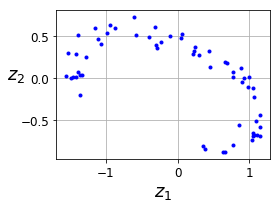

In [ ]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3386 - rounded_accuracy: 0.8866 - val_loss: 0.3118 - val_rounded_accuracy: 0.9128
Epoch 2/20
55000/55000 [==============================] - 4s 64us/sample - loss: 0.3055 - rounded_accuracy: 0.9153 - val_loss: 0.3030 - val_rounded_accuracy: 0.9200
Epoch 3/20
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2986 - rounded_accuracy: 0.9214 - val_loss: 0.2982 - val_rounded_accuracy: 0.9249
Epoch 4/20
55000/55000 [==============================] - 4s 67us/sample - loss: 0.2946 - rounded_accuracy: 0.9251 - val_loss: 0.2938 - val_rounded_accuracy: 0.9284
Epoch 5/20
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2921 - rounded_accuracy: 0.9273 - val_loss: 0.2922 - val_rounded_accuracy: 0.9302
Epoch 6/20
55000/55000 [==============================] - 4s 69us/sample - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss:

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


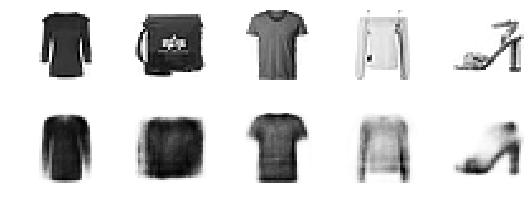

In [ ]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

# Visualizing Fashion MNIST

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

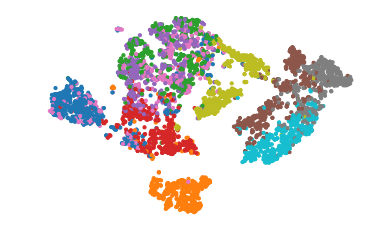

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

Saving figure fashion_mnist_visualization_plot


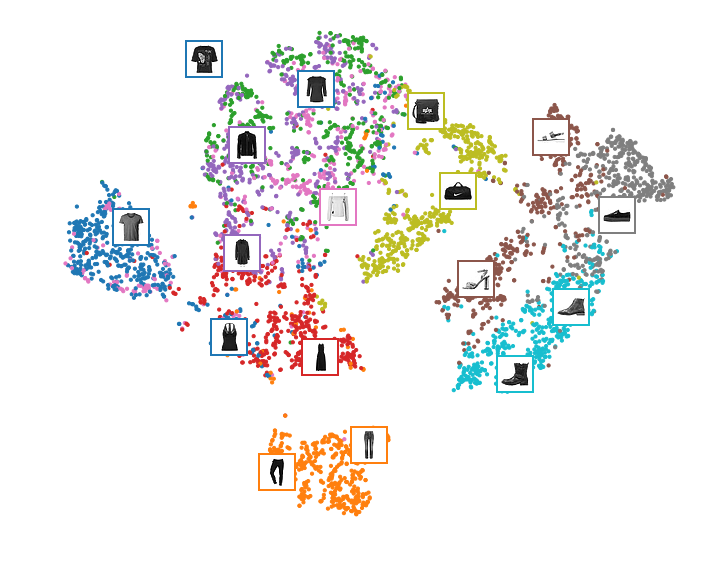

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.3213 - rounded_accuracy: 0.8996 - val_loss: 0.3038 - val_rounded_accuracy: 0.9154
Epoch 2/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.2967 - rounded_accuracy: 0.9216 - val_loss: 0.2931 - val_rounded_accuracy: 0.9268
Epoch 3/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2916 - rounded_accuracy: 0.9263 - val_loss: 0.2929 - val_rounded_accuracy: 0.9254
Epoch 4/10
55000/55000 [==============================] - 4s 64us/sample - loss: 0.2889 - rounded_accuracy: 0.9287 - val_loss: 0.2905 - val_rounded_accuracy: 0.9316
Epoch 5/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2871 - rounded_accuracy: 0.9303 - val_loss: 0.2917 - val_rounded_accuracy: 0.9307
Epoch 6/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2858 - rounded_accuracy: 0.9316 - val_loss:

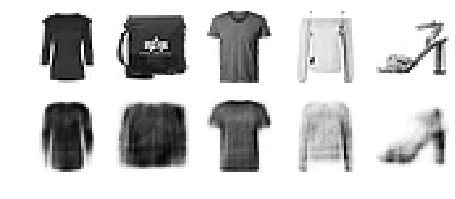

In [ ]:
show_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a Time

In [ ]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3446 - rounded_accuracy: 0.8874 - val_loss: 0.3122 - val_rounded_accuracy: 0.9147
Epoch 2/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3039 - rounded_accuracy: 0.9204 - val_loss: 0.3006 - val_rounded_accuracy: 0.9241
Epoch 3/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2933 - val_rounded_accuracy: 0.9319
Epoch 4/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2890 - rounded_accuracy: 0.9343 - val_loss: 0.2887 - val_rounded_accuracy: 0.9362
Epoch 5/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.2853 - rounded_accuracy: 0.9379 - val_loss: 0.2856 - val_rounded_accuracy: 0.9390
Epoch 6/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.2826 - rounded_accuracy: 0.9404 - val_loss:

In [ ]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

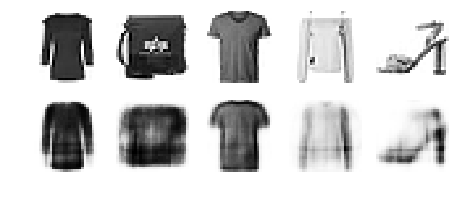

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [ ]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.2853 - rounded_accuracy: 0.9359 - val_loss: 0.2868 - val_rounded_accuracy: 0.9361
Epoch 2/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2849 - rounded_accuracy: 0.9363 - val_loss: 0.2866 - val_rounded_accuracy: 0.9364
Epoch 3/10
55000/55000 [==============================] - 4s 66us/sample - loss: 0.2847 - rounded_accuracy: 0.9365 - val_loss: 0.2864 - val_rounded_accuracy: 0.9362
Epoch 4/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2846 - rounded_accuracy: 0.9366 - val_loss: 0.2863 - val_rounded_accuracy: 0.9367
Epoch 5/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.2844 - rounded_accuracy: 0.9368 - val_loss: 0.2862 - val_rounded_accuracy: 0.9369
Epoch 6/10
55000/55000 [==============================] - 4s 66us/sample - loss: 0.2843 - rounded_accuracy: 0.9369 - val_loss:

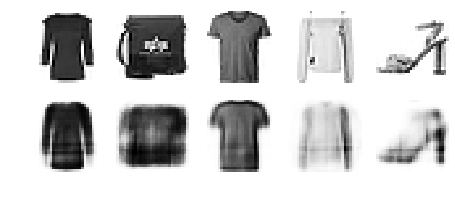

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 40s 734us/sample - loss: 0.3017 - accuracy: 0.5064 - val_loss: 0.2842 - val_accuracy: 0.5058
Epoch 2/5
55000/55000 [==============================] - 39s 712us/sample - loss: 0.2756 - accuracy: 0.5088 - val_loss: 0.2739 - val_accuracy: 0.5058
Epoch 3/5
55000/55000 [==============================] - 39s 715us/sample - loss: 0.2709 - accuracy: 0.5092 - val_loss: 0.2720 - val_accuracy: 0.5059
Epoch 4/5
55000/55000 [==============================] - 39s 707us/sample - loss: 0.2682 - accuracy: 0.5094 - val_loss: 0.2685 - val_accuracy: 0.5063
Epoch 5/5
55000/55000 [==============================] - 39s 706us/sample - loss: 0.2665 - accuracy: 0.5095 - val_loss: 0.2671 - val_accuracy: 0.5066


In [ ]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

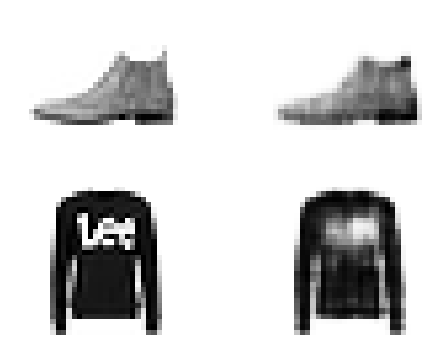

In [ ]:
show_reconstructions(conv_ae)
plt.show()

# Recurrent Autoencoders

In [ ]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [ ]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 79s 1ms/sample - loss: 0.5165 - rounded_accuracy: 0.7363 - val_loss: 0.4489 - val_rounded_accuracy: 0.8137
Epoch 2/10
55000/55000 [==============================] - 78s 1ms/sample - loss: 0.4049 - rounded_accuracy: 0.8415 - val_loss: 0.3762 - val_rounded_accuracy: 0.8650
Epoch 3/10
55000/55000 [==============================] - 80s 1ms/sample - loss: 0.3662 - rounded_accuracy: 0.8703 - val_loss: 0.3626 - val_rounded_accuracy: 0.8730
Epoch 4/10
55000/55000 [==============================] - 80s 1ms/sample - loss: 0.3505 - rounded_accuracy: 0.8808 - val_loss: 0.3483 - val_rounded_accuracy: 0.8838
Epoch 5/10
55000/55000 [==============================] - 82s 1ms/sample - loss: 0.3398 - rounded_accuracy: 0.8881 - val_loss: 0.3345 - val_rounded_accuracy: 0.8941
Epoch 6/10
55000/55000 [==============================] - 93s 2ms/sample - loss: 0.3328 - rounded_accuracy: 0.8930 - val_loss:

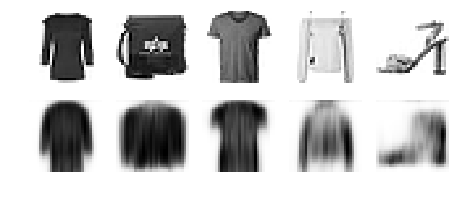

In [ ]:
show_reconstructions(recurrent_ae)
plt.show()

# Stacked denoising Autoencoder

Using Gaussian noise:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.3508 - rounded_accuracy: 0.8768 - val_loss: 0.3231 - val_rounded_accuracy: 0.9065
Epoch 2/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3125 - rounded_accuracy: 0.9093 - val_loss: 0.3077 - val_rounded_accuracy: 0.9153
Epoch 3/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3061 - rounded_accuracy: 0.9149 - val_loss: 0.3034 - val_rounded_accuracy: 0.9190
Epoch 4/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3025 - rounded_accuracy: 0.9181 - val_loss: 0.3007 - val_rounded_accuracy: 0.9195
Epoch 5/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2980 - val_rounded_accuracy: 0.9230
Epoch 6/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.2979 - rounded_accuracy: 0.9220 - val_loss:

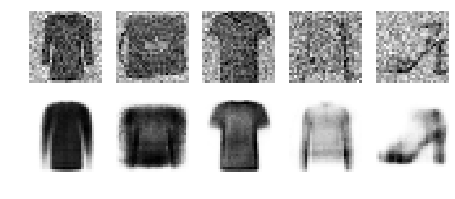

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.3564 - accuracy: 0.4969 - val_loss: 0.3206 - val_accuracy: 0.5011
Epoch 2/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3182 - accuracy: 0.5034 - val_loss: 0.3113 - val_accuracy: 0.5014
Epoch 3/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3130 - accuracy: 0.5042 - val_loss: 0.3079 - val_accuracy: 0.5012
Epoch 4/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3091 - accuracy: 0.5048 - val_loss: 0.3037 - val_accuracy: 0.5026
Epoch 5/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3066 - accuracy: 0.5052 - val_loss: 0.3032 - val_accuracy: 0.5016
Epoch 6/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3047 - accuracy: 0.5054 - val_loss: 0.3001 - val_accuracy: 0.5032
Epoch 7/10
55000/55000 [==============================] -

Saving figure dropout_denoising_plot


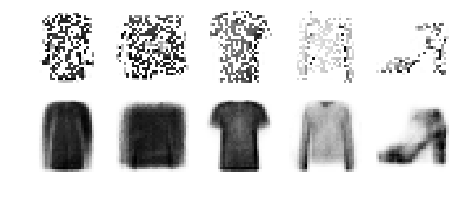

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# Sparse Autoencoder

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.4331 - accuracy: 0.4906 - val_loss: 0.3778 - val_accuracy: 0.4911
Epoch 2/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.3610 - accuracy: 0.4976 - val_loss: 0.3510 - val_accuracy: 0.4972
Epoch 3/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3405 - accuracy: 0.5006 - val_loss: 0.3359 - val_accuracy: 0.4990
Epoch 4/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3276 - accuracy: 0.5027 - val_loss: 0.3248 - val_accuracy: 0.5003
Epoch 5/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3206 - accuracy: 0.5035 - val_loss: 0.3206 - val_accuracy: 0.5007
Epoch 6/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3172 - accuracy: 0.5038 - val_loss: 0.3176 - val_accuracy: 0.5010
Epoch 7/10
55000/55000 [==============================] -

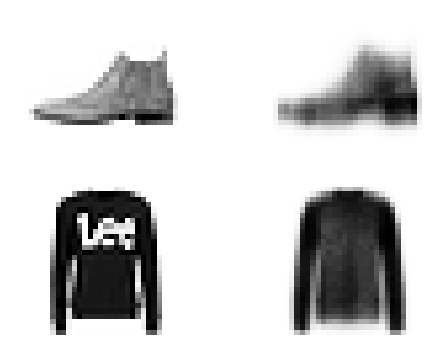

In [ ]:
show_reconstructions(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [ ]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

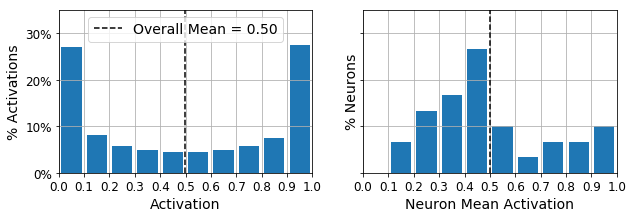

In [ ]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add $\ell_1$ regularization to the coding layer:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.4306 - accuracy: 0.4947 - val_loss: 0.3819 - val_accuracy: 0.4897
Epoch 2/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3689 - accuracy: 0.4971 - val_loss: 0.3639 - val_accuracy: 0.4940
Epoch 3/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3553 - accuracy: 0.4987 - val_loss: 0.3513 - val_accuracy: 0.4970
Epoch 4/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3443 - accuracy: 0.5003 - val_loss: 0.3428 - val_accuracy: 0.4964
Epoch 5/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3379 - accuracy: 0.5009 - val_loss: 0.3372 - val_accuracy: 0.4979
Epoch 6/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3332 - accuracy: 0.5015 - val_loss: 0.3329 - val_accuracy: 0.4980
Epoch 7/10
55000/55000 [==============================] -

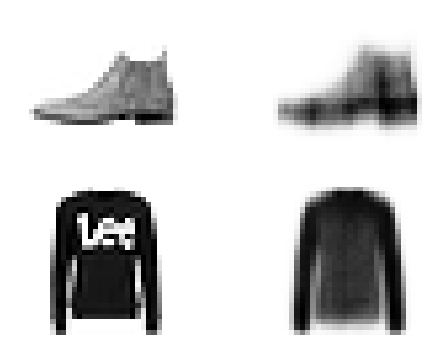

In [ ]:
show_reconstructions(sparse_l1_ae)

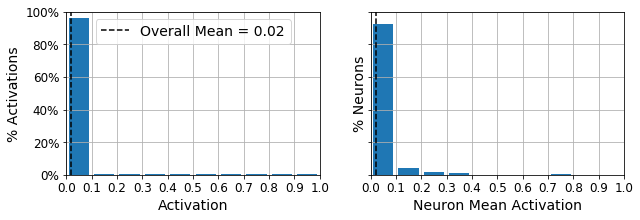

In [ ]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

Saving figure sparsity_loss_plot


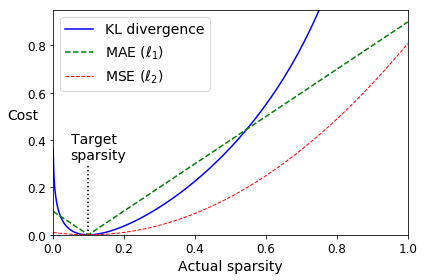

In [ ]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.4151 - rounded_accuracy: 0.8121 - val_loss: 0.3714 - val_rounded_accuracy: 0.8560
Epoch 2/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.3532 - rounded_accuracy: 0.8762 - val_loss: 0.3442 - val_rounded_accuracy: 0.8842
Epoch 3/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.3340 - rounded_accuracy: 0.8919 - val_loss: 0.3292 - val_rounded_accuracy: 0.8976
Epoch 4/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9040
Epoch 5/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.3170 - rounded_accuracy: 0.9062 - val_loss: 0.3170 - val_rounded_accuracy: 0.9075
Epoch 6/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.3134 - rounded_accuracy: 0.9093 - val_loss

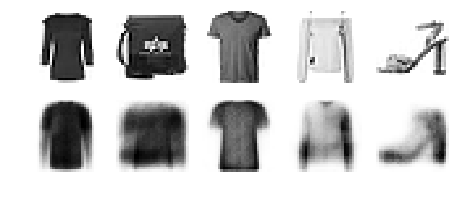

In [ ]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


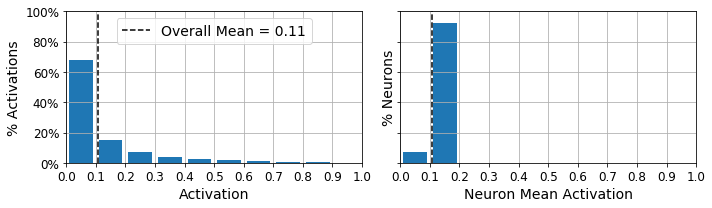

In [ ]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# Variational Autoencoder

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 84us/sample - loss: 0.3889 - rounded_accuracy: 0.8608 - val_loss: 0.3592 - val_rounded_accuracy: 0.8840
Epoch 2/25
55000/55000 [==============================] - 3s 60us/sample - loss: 0.3429 - rounded_accuracy: 0.8974 - val_loss: 0.3369 - val_rounded_accuracy: 0.8982
Epoch 3/25
55000/55000 [==============================] - 3s 53us/sample - loss: 0.3329 - rounded_accuracy: 0.9050 - val_loss: 0.3356 - val_rounded_accuracy: 0.9022
Epoch 4/25
55000/55000 [==============================] - 3s 61us/sample - loss: 0.3275 - rounded_accuracy: 0.9092 - val_loss: 0.3255 - val_rounded_accuracy: 0.9105
Epoch 5/25
55000/55000 [==============================] - 3s 59us/sample - loss: 0.3243 - rounded_accuracy: 0.9119 - val_loss: 0.3232 - val_rounded_accuracy: 0.9169
Epoch 6/25
55000/55000 [==============================] - 3s 58us/sample - loss: 0.3219 - rounded_accuracy: 0.9138 - val_loss:

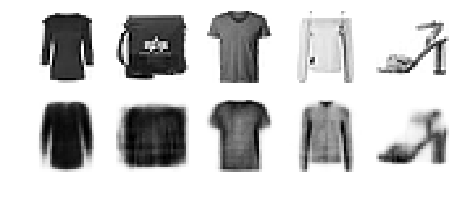

In [ ]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

Saving figure vae_generated_images_plot


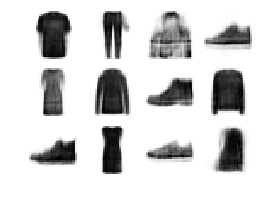

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Now let's perform semantic interpolation between these images:

Saving figure semantic_interpolation_plot


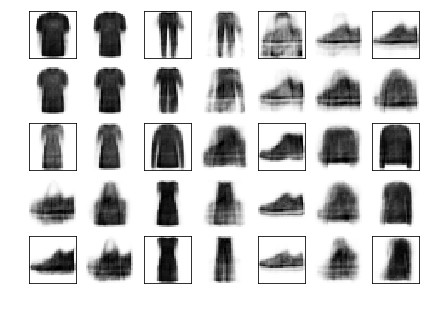

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

# Generative Adversarial Networks

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Epoch 1/1


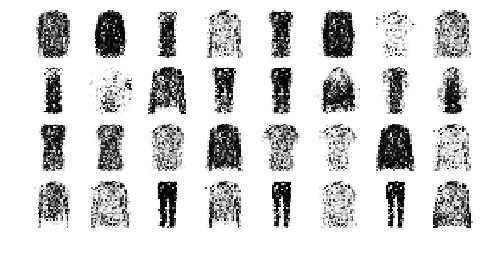

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Saving figure gan_generated_images_plot


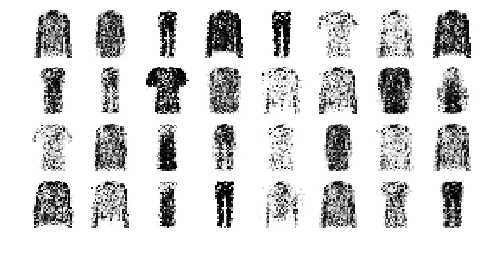

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

Epoch 1/50


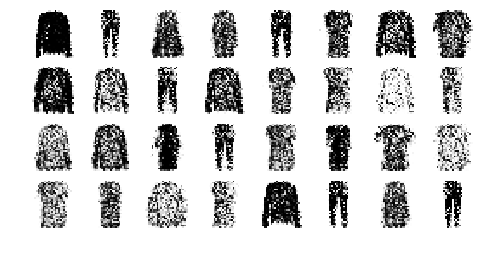

Epoch 2/50


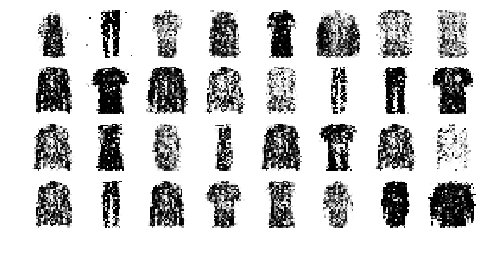

Epoch 3/50


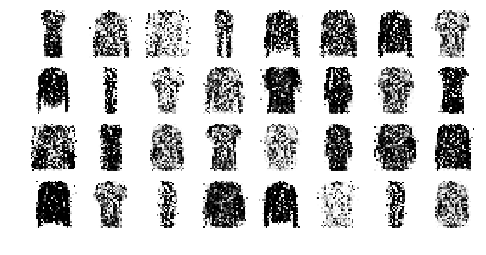

Epoch 4/50


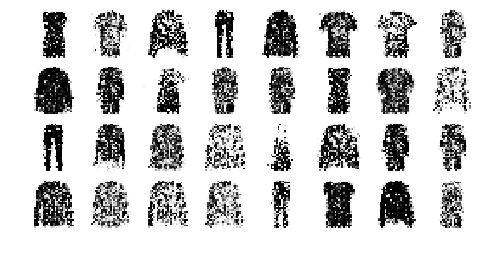

Epoch 5/50


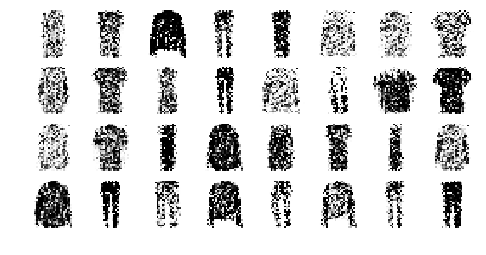

Epoch 6/50


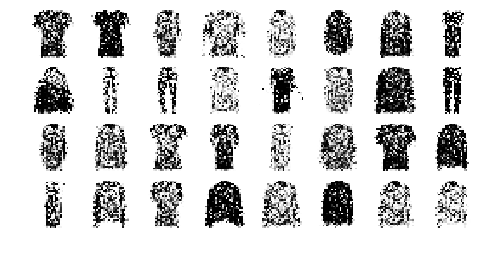

Epoch 7/50


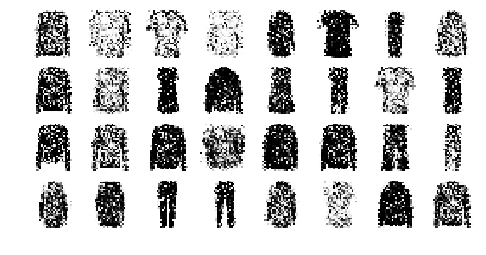

Epoch 8/50


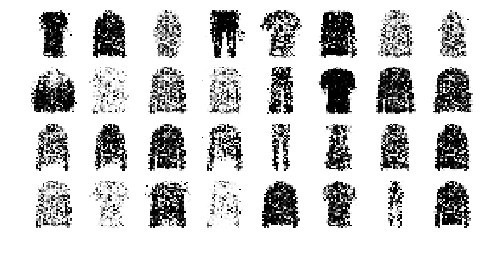

Epoch 9/50


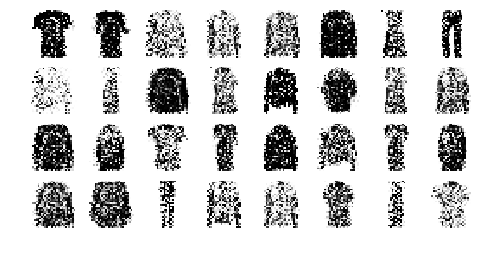

Epoch 10/50


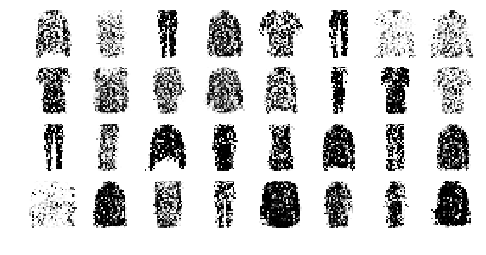

Epoch 11/50


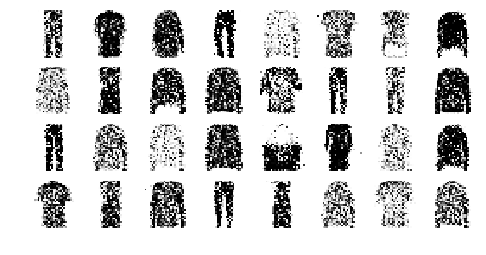

Epoch 12/50


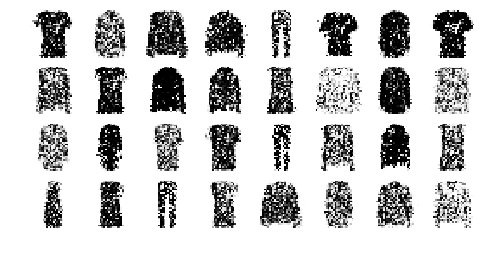

Epoch 13/50


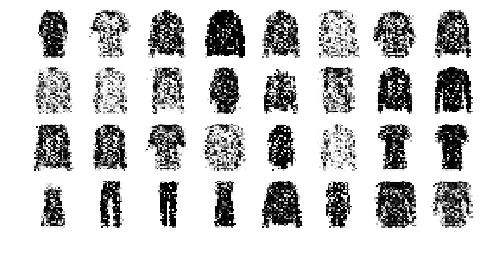

Epoch 14/50


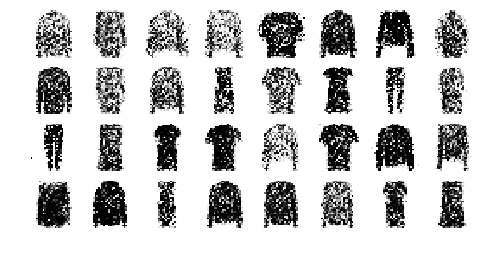

Epoch 15/50


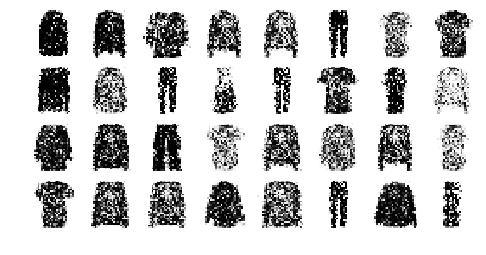

Epoch 16/50


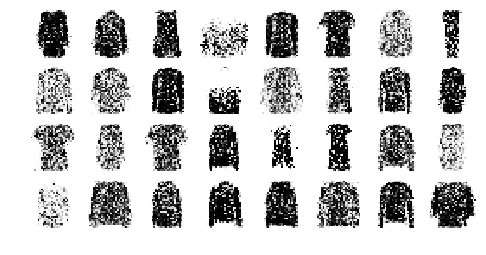

Epoch 17/50


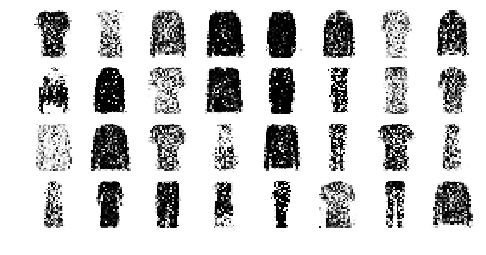

Epoch 18/50


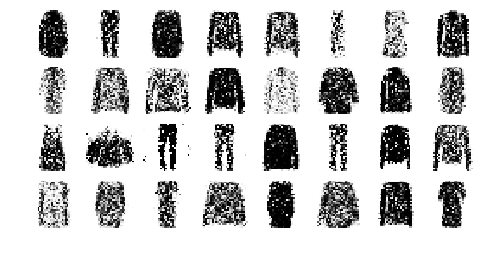

Epoch 19/50


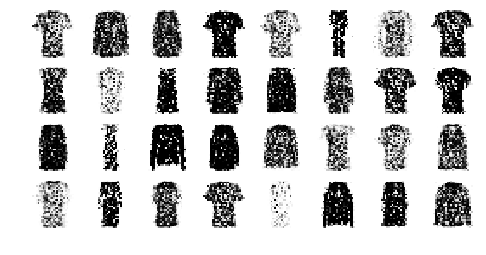

Epoch 20/50


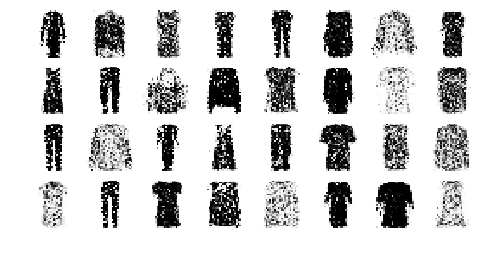

Epoch 21/50


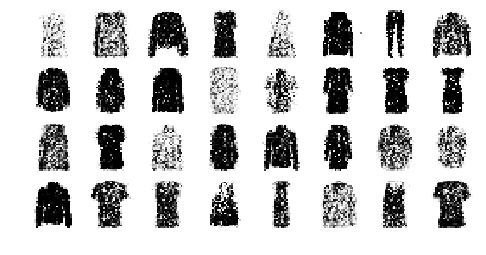

Epoch 22/50


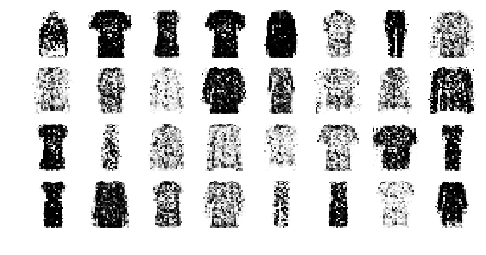

Epoch 23/50


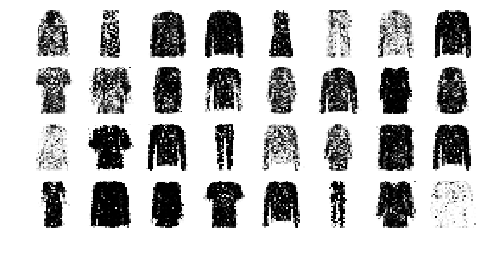

Epoch 24/50


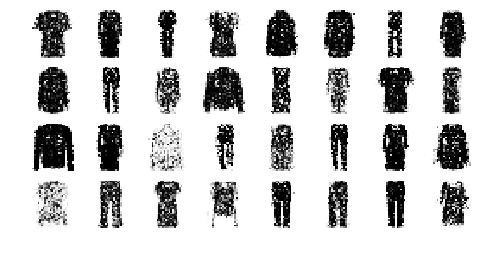

Epoch 25/50


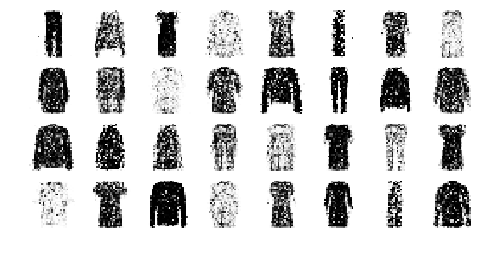

Epoch 26/50


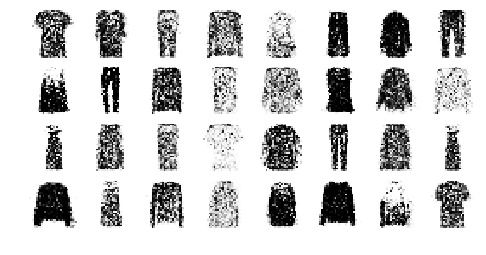

Epoch 27/50


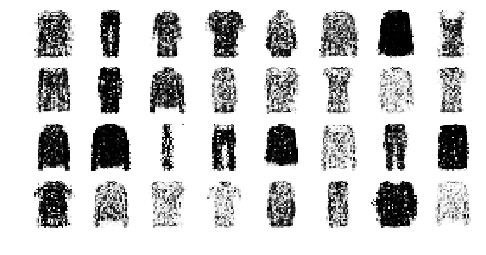

Epoch 28/50


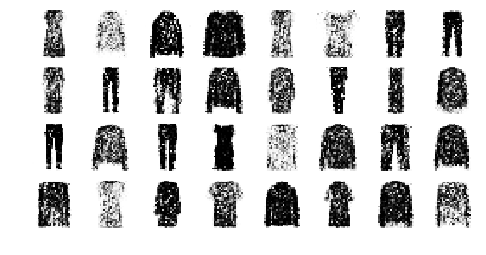

Epoch 29/50


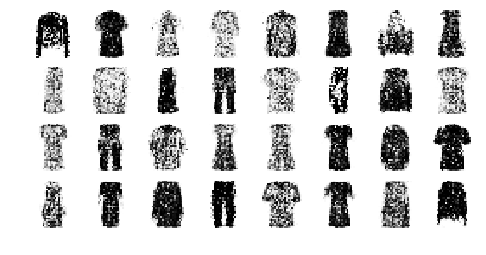

Epoch 30/50


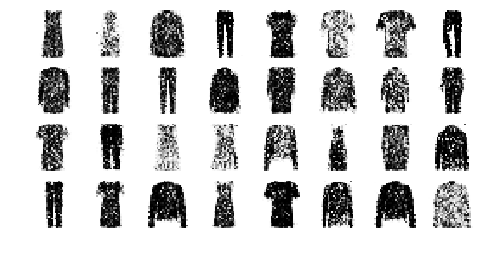

Epoch 31/50


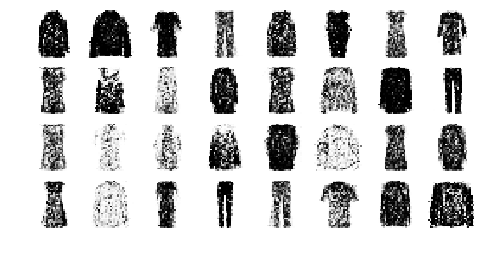

Epoch 32/50


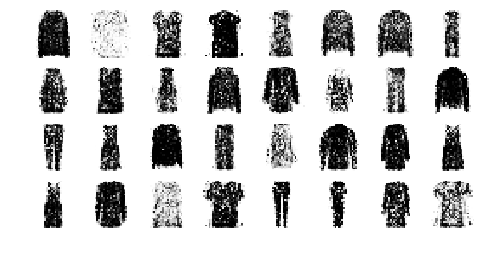

Epoch 33/50


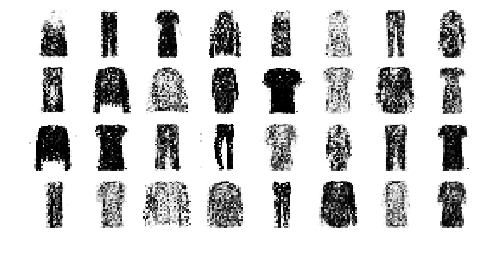

Epoch 34/50


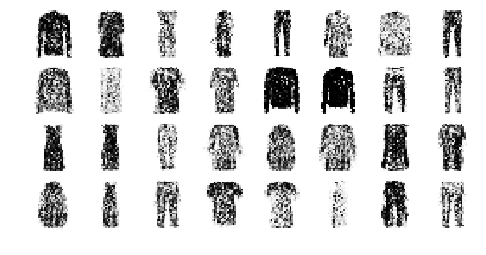

Epoch 35/50


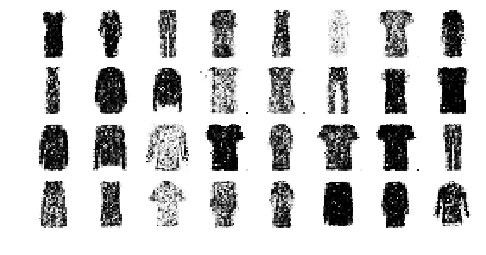

Epoch 36/50


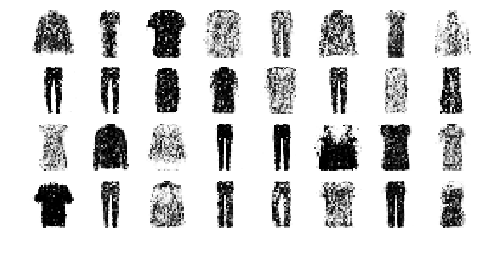

Epoch 37/50


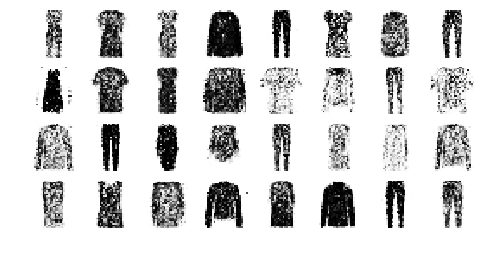

Epoch 38/50


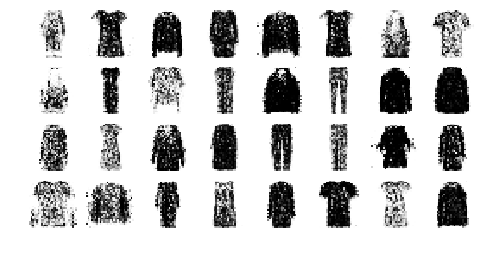

Epoch 39/50


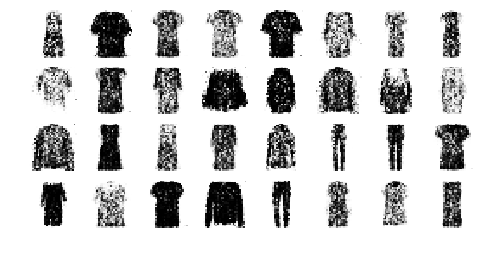

Epoch 40/50


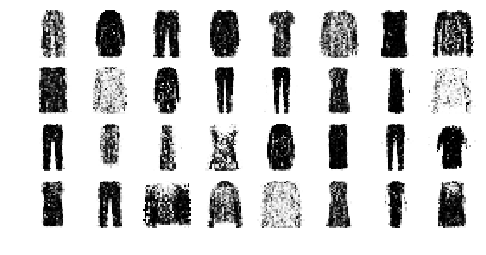

Epoch 41/50


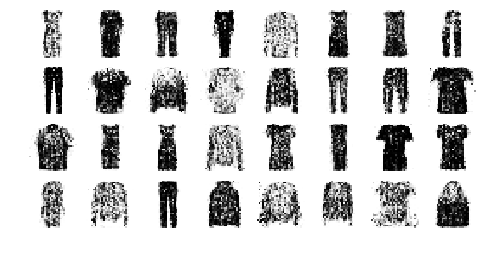

Epoch 42/50


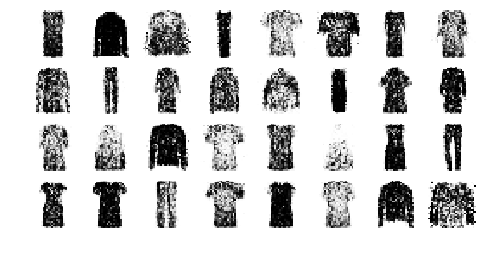

Epoch 43/50


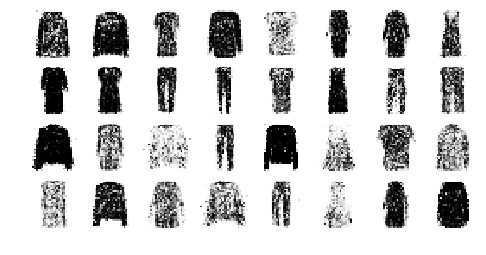

Epoch 44/50


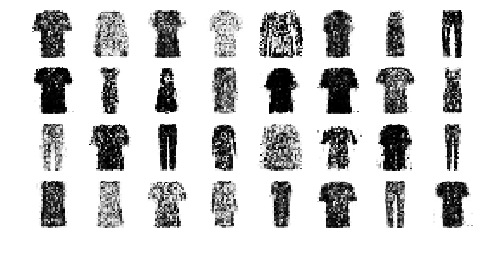

Epoch 45/50


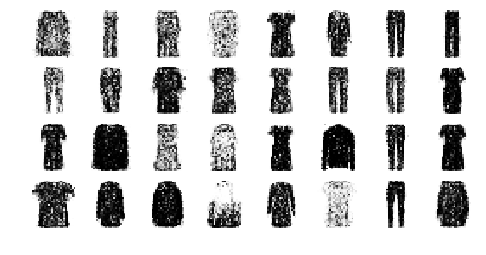

Epoch 46/50


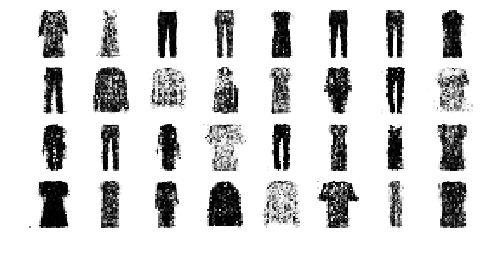

Epoch 47/50


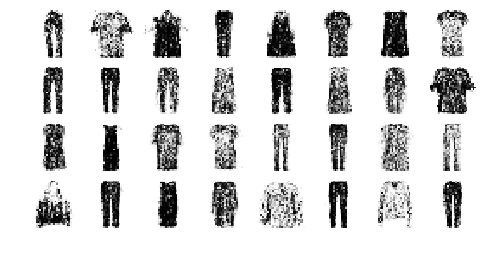

Epoch 48/50


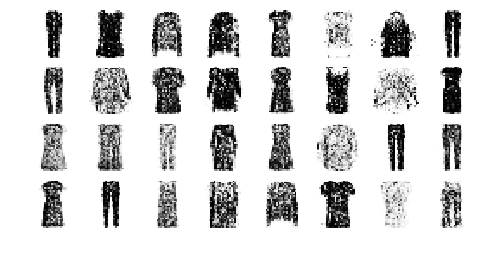

Epoch 49/50


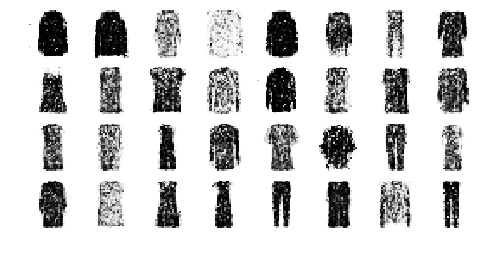

Epoch 50/50


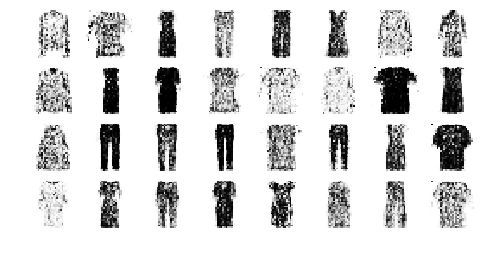

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

# Deep Convolutional GAN

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50
Saving figure gan_generated_images_plot


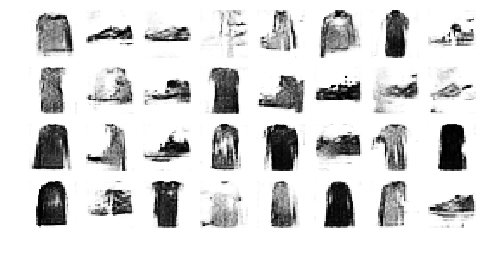

Epoch 2/50


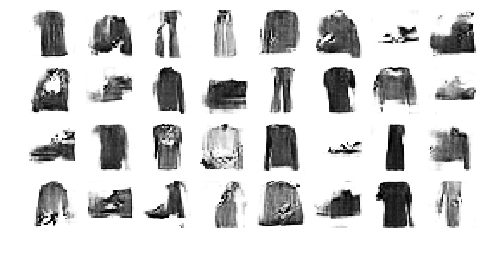

Epoch 3/50


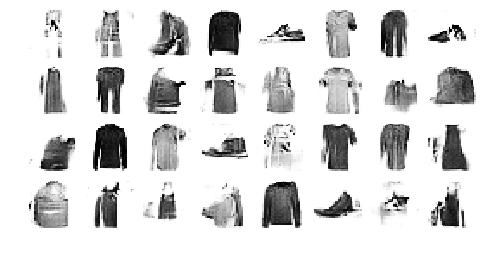

Epoch 4/50


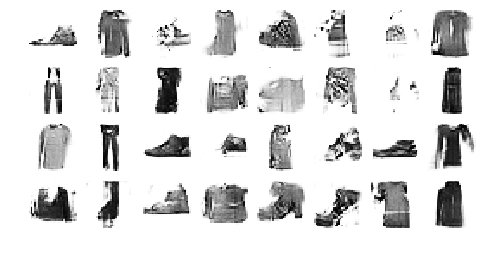

Epoch 5/50


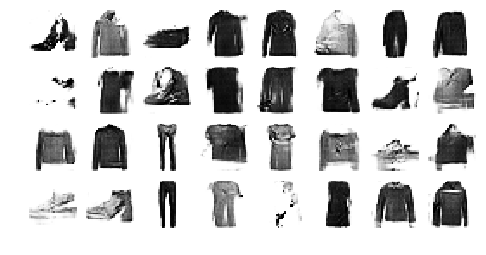

Epoch 6/50


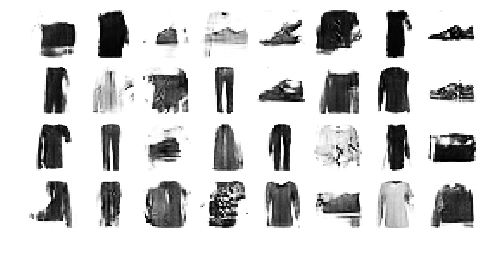

Epoch 7/50


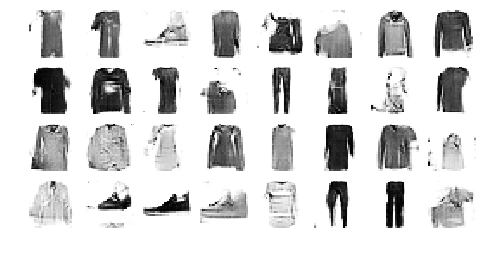

Epoch 8/50


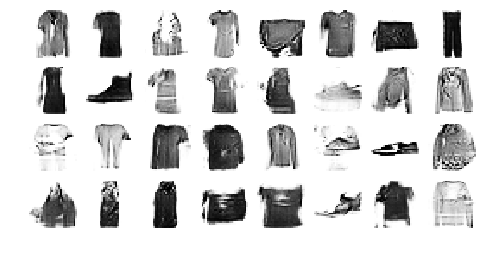

Epoch 9/50


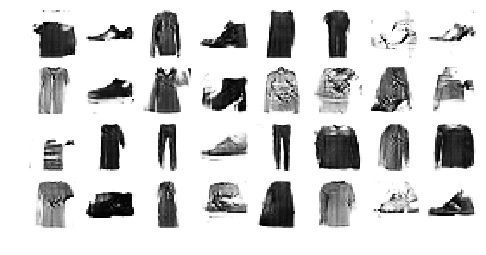

Epoch 10/50


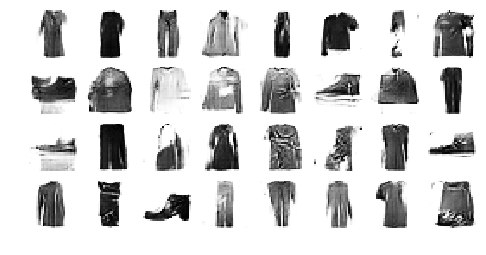

Epoch 11/50


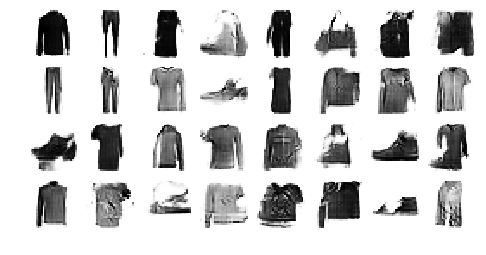

Epoch 12/50


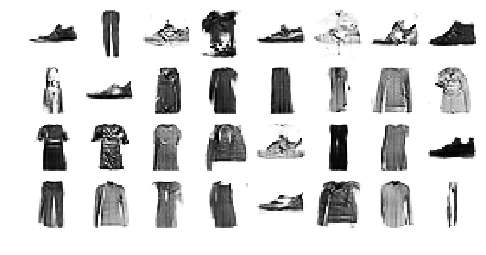

Epoch 13/50


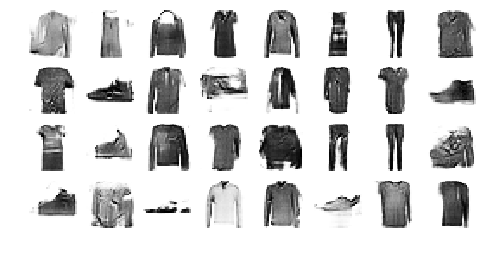

Epoch 14/50


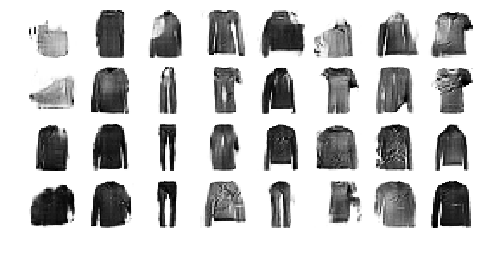

Epoch 15/50


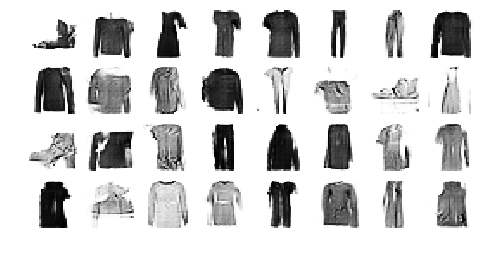

Epoch 16/50


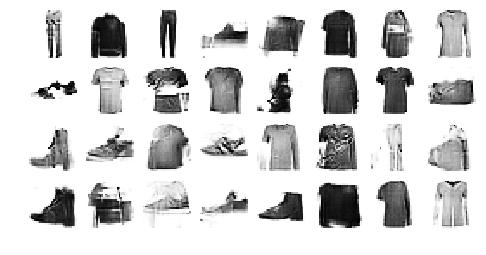

Epoch 17/50


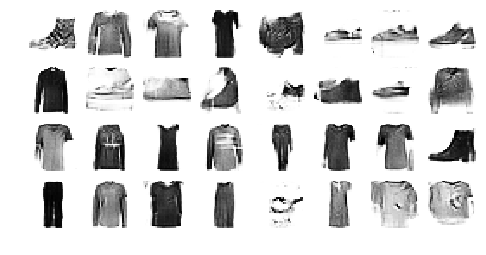

Epoch 18/50


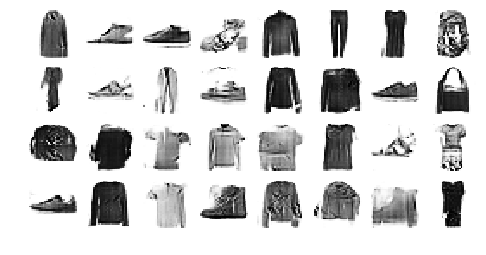

Epoch 19/50


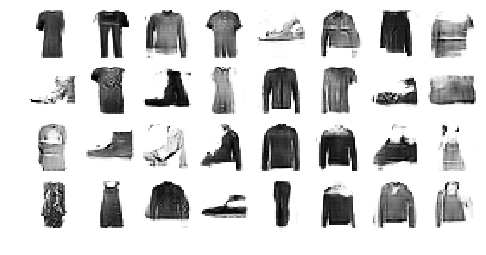

Epoch 20/50


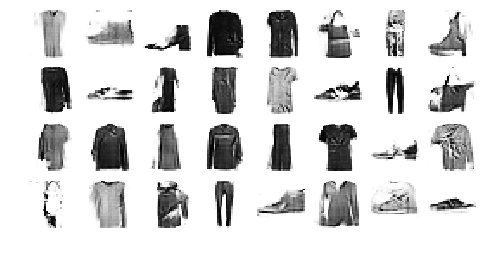

Epoch 21/50


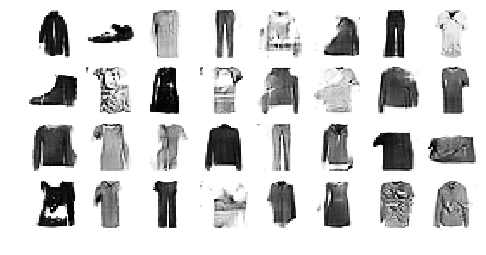

Epoch 22/50


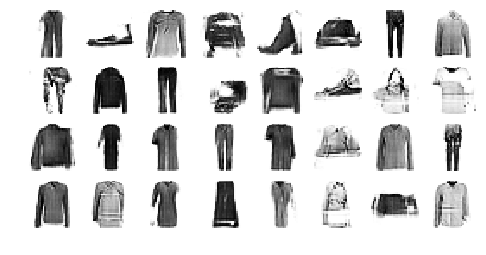

Epoch 23/50


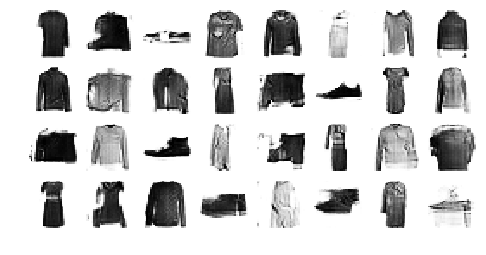

Epoch 24/50


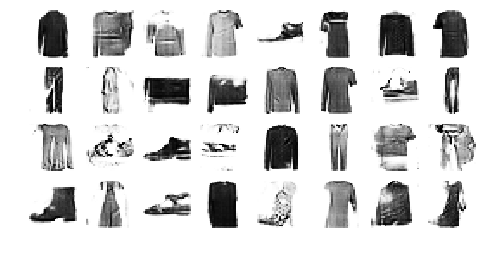

Epoch 25/50


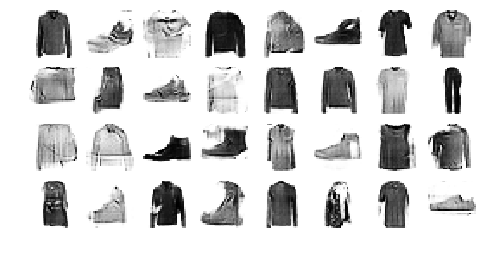

Epoch 26/50


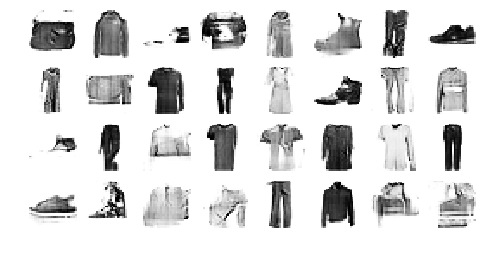

Epoch 27/50


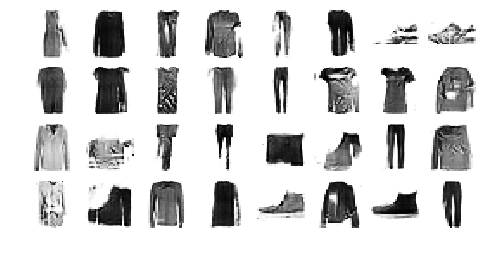

Epoch 28/50


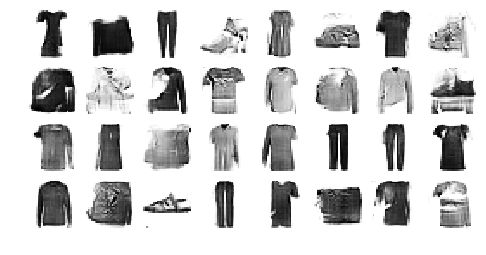

Epoch 29/50


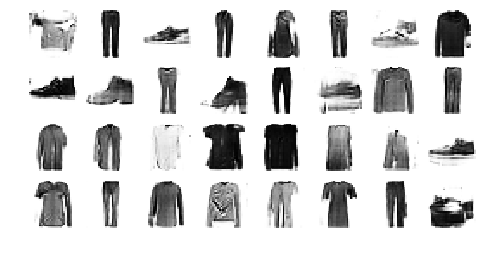

Epoch 30/50


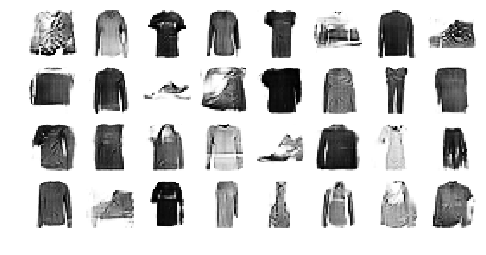

Epoch 31/50


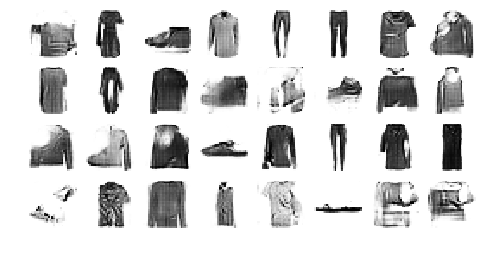

Epoch 32/50


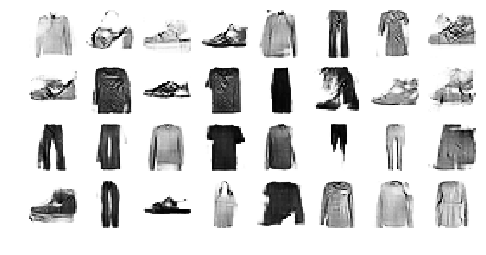

Epoch 33/50


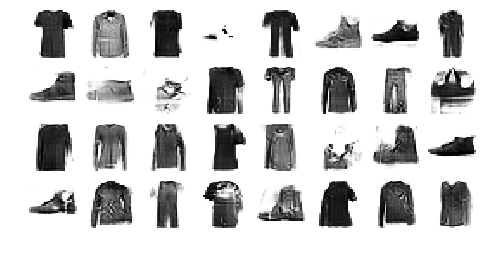

Epoch 34/50


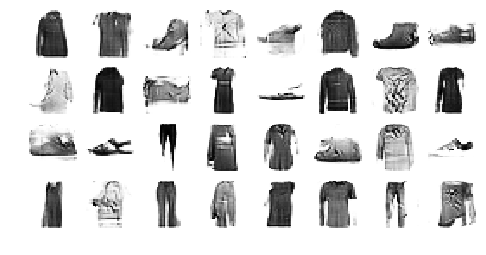

Epoch 35/50


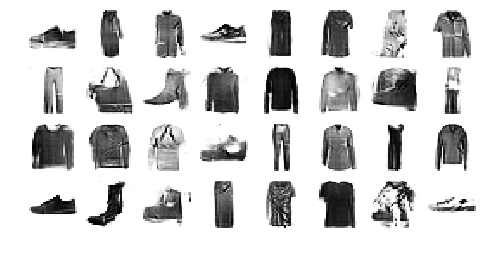

Epoch 36/50


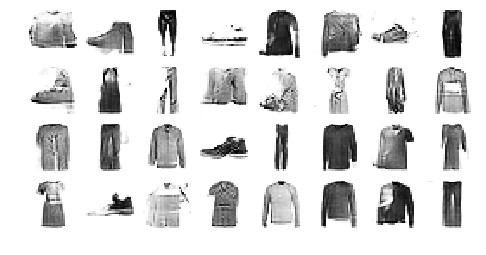

Epoch 37/50


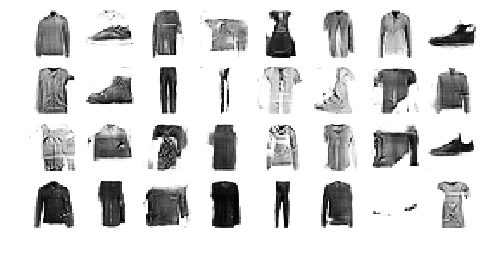

Epoch 38/50


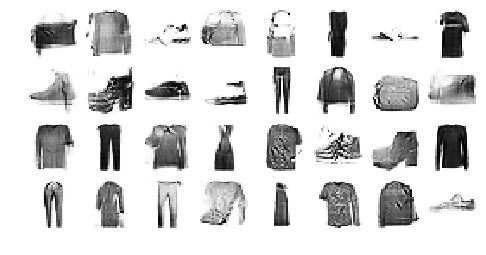

Epoch 39/50


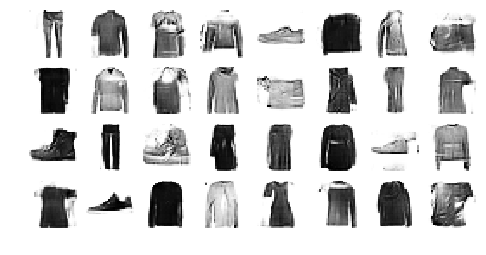

Epoch 40/50


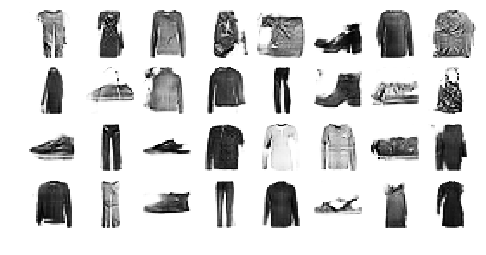

Epoch 41/50


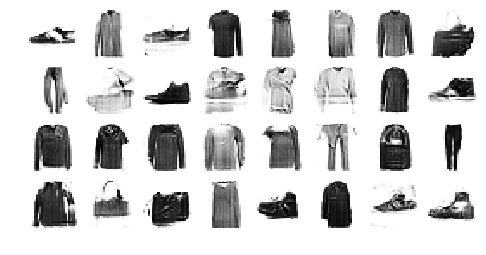

Epoch 42/50


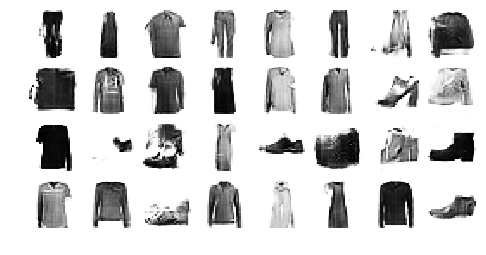

Epoch 43/50


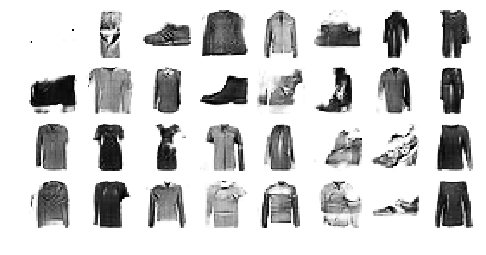

Epoch 44/50


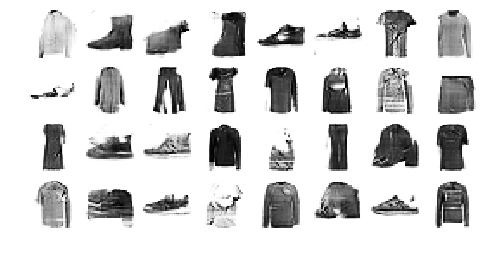

Epoch 45/50


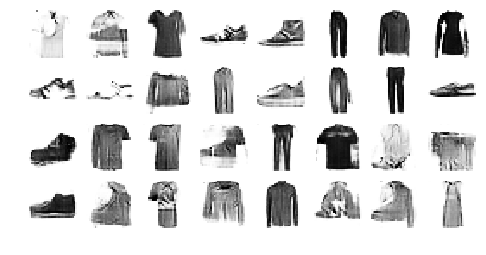

Epoch 46/50


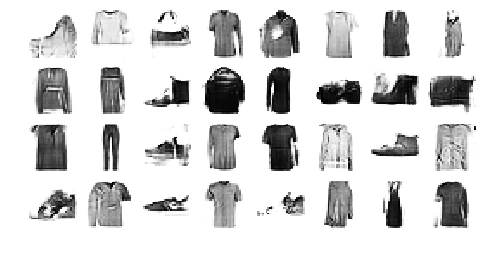

Epoch 47/50


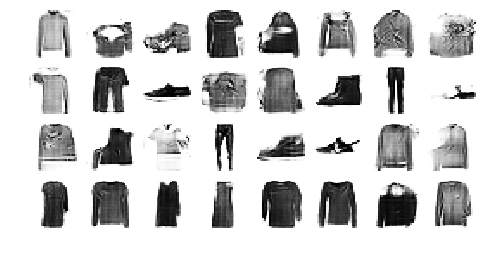

Epoch 48/50


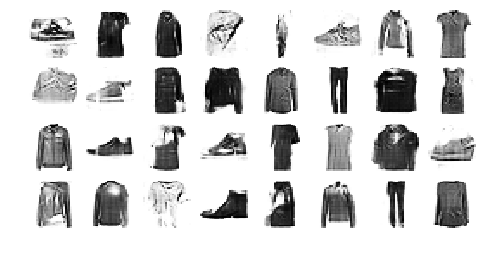

Epoch 49/50


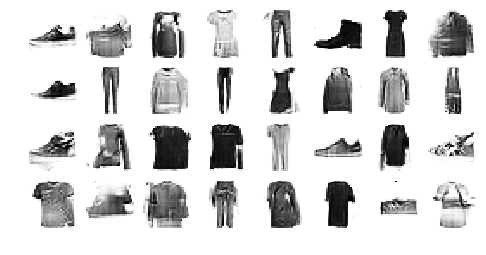

Epoch 50/50


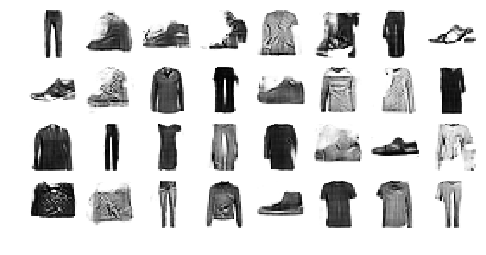

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

Saving figure dcgan_generated_images_plot


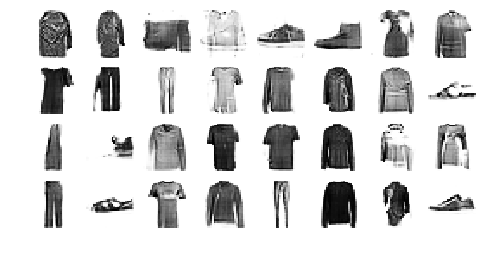

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

# Extra Material

## Hashing Using a Binary Autoencoder

Let's load the Fashion MNIST dataset again:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's train an autoencoder where the encoder has a 16-neuron output layer, using the sigmoid activation function, and heavy Gaussian noise just before it. During training, the noise layer will encourage the previous layer to learn to output large values, since small values will just be crushed by the noise. In turn, this means that the output layer will output values close to 0 or 1, thanks to the sigmoid activation function. Once we round the output values to 0s and 1s, we get a 16-bit "semantic" hash. If everything works well, images that look alike will have the same hash. This can be very useful for search engines: for example, if we store each image on a server identified by the image's semantic hash, then all similar images will end up on the same server. Users of the search engine can then provide an image to search for, and the search engine will compute the image's hash using the encoder, and quickly return all the images on the server identified by that hash.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                   metrics=[rounded_accuracy])
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4462 - rounded_accuracy: 0.7827 - val_loss: 0.3881 - val_rounded_accuracy: 0.8251
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3712 - rounded_accuracy: 0.8455 - val_loss: 0.3706 - val_rounded_accuracy: 0.8402
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3587 - rounded_accuracy: 0.8567 - val_loss: 0.3619 - val_rounded_accuracy: 0.8514
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3532 - rounded_accuracy: 0.8631 - val_loss: 0.3559 - val_rounded_accuracy: 0.8614
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3486 - rounded_accuracy: 0.8680 - val_loss: 0.3472 - val_rounded_accuracy: 0.8689
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3467 - rounded_accuracy: 0.8704 - val_loss: 0.3448 - val_rounded_accuracy: 0.8747
Epoch 7/10
1719/1719 [==================

The autoencoder compresses the information so much (down to 16 bits!) that it's quite lossy, but that's okay, we're using it to produce semantic hashes, not to perfectly reconstruct the images:

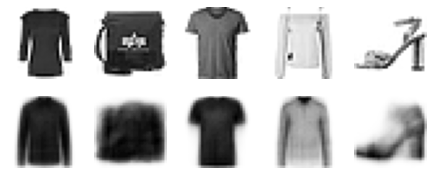

In [ ]:
show_reconstructions(hashing_ae)
plt.show()

Notice that the outputs are indeed very close to 0 or 1 (left graph):

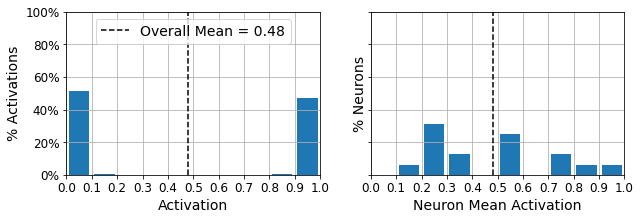

In [ ]:
plot_activations_histogram(hashing_encoder)
plt.show()

Now let's see what the hashes look like for the first few images in the validation set:

In [ ]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

0000100101011011
0000100100110011
0100100100011011
0001100111001010
0001010100110000
...


Now let's find the most common image hashes in the validation set, and display a few images for each hash. In the following image, all the images on a given row have the same hash:

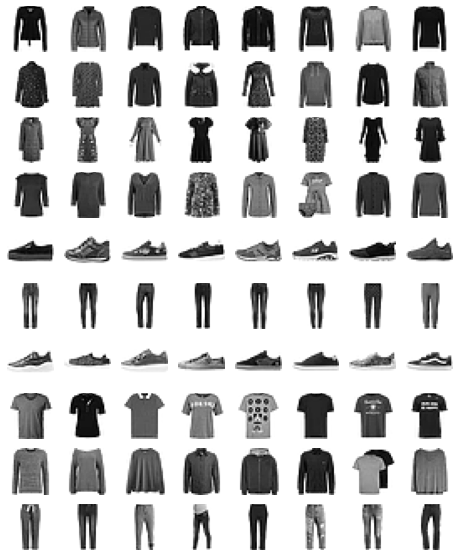

In [ ]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Exercise Solutions

## 1. to 8.

See Appendix A.

## 9.
_Exercise: Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as [CIFAR10](https://homl.info/122) if you want a bigger challenge. Regardless of the dataset you're using, follow these steps:_
* Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
* Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
* Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

In [ ]:
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

In [ ]:
denoising_encoder.summary()

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_36 (GaussianN (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 512)               4194816   
Total params: 4,195,712
Trainable params: 4,195,712
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation="relu", input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

In [ ]:
denoising_decoder.summary()

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 8192)              4202496   
_________________________________________________________________
reshape_22 (Reshape)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_transpose_62 (Conv2DT (None, 32, 32, 3)         867       
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 160s 3ms/sample - loss: 0.5936 - mse: 0.0187 - val_loss: 0.5849 - val_mse: 0.0143
Epoch 2/10
50000/50000 [==============================] - 169s 3ms/sample - loss: 0.5727 - mse: 0.0100 - val_loss: 0.5783 - val_mse: 0.0117
Epoch 3/10
50000/50000 [==============================] - 183s 4ms/sample - loss: 0.5676 - mse: 0.0080 - val_loss: 0.5715 - val_mse: 0.0090
Epoch 4/10
50000/50000 [==============================] - 182s 4ms/sample - loss: 0.5653 - mse: 0.0071 - val_loss: 0.5695 - val_mse: 0.0083
Epoch 5/10
50000/50000 [==============================] - 185s 4ms/sample - loss: 0.5639 - mse: 0.0066 - val_loss: 0.5687 - val_mse: 0.0079
Epoch 6/10
50000/50000 [==============================] - 158s 3ms/sample - loss: 0.5629 - mse: 0.0062 - val_loss: 0.5669 - val_mse: 0.0072
Epoch 7/10
50000/50000 [==============================] - 157s 3ms/sample - loss: 0.5622 - mse: 0.0060 - val_l

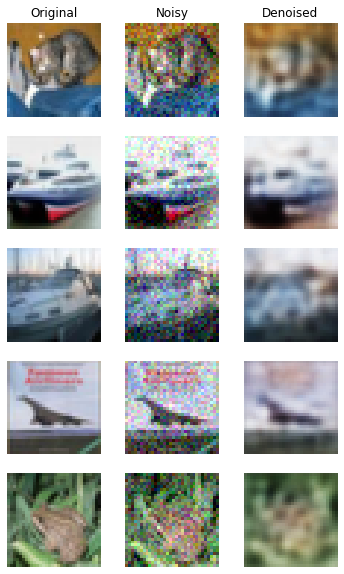

In [ ]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

## 10.
_Exercise: Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples._


Import needed packages and set up global variables.

In [43]:
# imports and globals
import tensorflow as tf
from tensorflow import keras
K = keras.backend
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import random

BATCH_SIZE = 32 

# images resized for consistency
IMG_WIDTH  = 48 
IMG_HEIGHT = 48 

ENCODING_SIZE = 16

tf.random.set_seed(4242)
random.seed(42)

Load TensorFlow flowers dataset.

In [44]:
# resize images, scale, and return image as target output
def preprocess(image, label):
    resized_image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    return resized_image / 255, resized_image / 255 

# load complete flowers dataset
(train_set_raw, valid_set_raw), info = tfds.load("tf_flowers", 
                                                 split = ["train[:90%]", "train[90%:]"],
                                                 as_supervised = True,
                                                 with_info = True)

flower_names = info.features["label"].names

train_set = train_set_raw.shuffle(5000, reshuffle_each_iteration = True).repeat()
train_set = train_set.map(preprocess).batch(BATCH_SIZE).prefetch(1)

valid_set = valid_set_raw.map(preprocess).batch(BATCH_SIZE).prefetch(1)

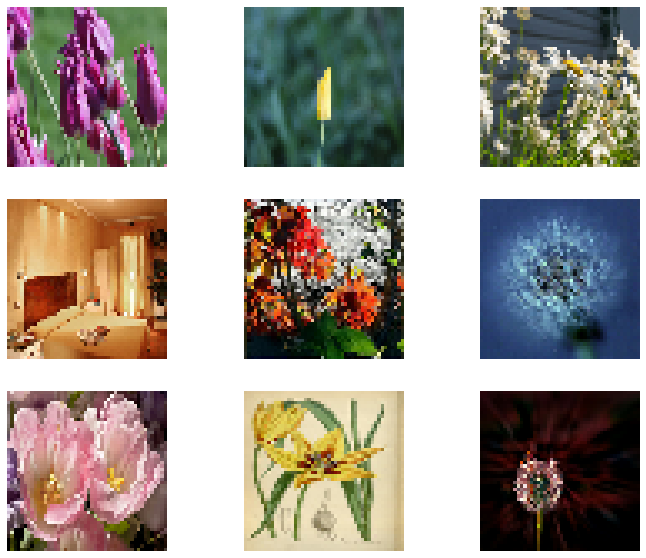

In [45]:
# visualize a few flowers
plt.figure(figsize=(12, 10))

for index, (images, labels) in enumerate(train_set.take(1)):
  for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(images[idx])
    plt.axis("off")

In [52]:
# build a VAE 
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var /2) + mean

inputs = keras.layers.Input(shape = [IMG_WIDTH, IMG_HEIGHT, 3])
z = keras.layers.Conv2D(64, input_shape = [IMG_WIDTH, IMG_HEIGHT, 3], kernel_size = 3, 
                        strides = 1, padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(inputs)
z = keras.layers.Conv2D(128, kernel_size = 3, strides = 2,
                        padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(z)
z = keras.layers.Conv2D(256, kernel_size = 3, strides = 2,
                        padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(z)
z = keras.layers.Conv2D(512, kernel_size = 3, strides = 2,
                        padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(z)
z = keras.layers.Flatten()(z)
codings_mean = keras.layers.Dense(ENCODING_SIZE)(z)
codings_log_var = keras.layers.Dense(ENCODING_SIZE)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs = [inputs], outputs = [codings_mean, codings_log_var, codings])

variational_encoder.summary()

decoder_inputs = keras.layers.Input(shape = [ENCODING_SIZE])
x = keras.layers.Dense(512 * 6 * 6, activation = "selu", input_shape = [ENCODING_SIZE])(decoder_inputs)
x = keras.layers.Reshape([6, 6, 512])(x)
x = keras.layers.Conv2DTranspose(filters = 512, kernel_size = 3, strides = 1,
                                 padding = "same", activation = "selu")(x)
x = keras.layers.Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "selu")(x)
x = keras.layers.Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "selu")(x)
x = keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "selu")(x)
outputs = keras.layers.Conv2DTranspose(filters = 3, kernel_size = 3, strides = 1,
                                       padding = 'same', activation = 'sigmoid')(x)
variational_decoder = keras.Model(inputs = [decoder_inputs], outputs = [outputs])

variational_decoder.summary()

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
vae = keras.Model(inputs = [inputs], outputs = [reconstructions])

vae.summary()

# add a loss function
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
                           axis = -1)
vae.add_loss(K.mean(latent_loss) / 27648.)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 24, 128)  73856       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 12, 12, 256)  295168      ['conv2d_1[0][0]']               
                                                                                              

In [53]:
# add learning rate scheduling 
def exponential_decay_fn(epoch):
  return 0.0001 * 0.1 ** (epoch / 10)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# add early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# clear the session for a clean run
keras.backend.clear_session()
# tf.random.set_seed(42)

# mean squared error loss used to avoid over-blurring of images when using binary cross-entropy
vae.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Nadam())
history = vae.fit(train_set, validation_data = valid_set,  epochs = 50,  
                  steps_per_epoch = int(5000 / BATCH_SIZE), # ~3300 in training set
                  validation_steps = int(365 / BATCH_SIZE), # ~365 in validation set
                  callbacks = [lr_scheduler, early_stopping_cb])


Epoch 1/50
156/156 [==============================] - 8s 38ms/step - loss: 0.0581 - val_loss: 0.0510 - lr: 1.0000e-04
Epoch 2/50
156/156 [==============================] - 6s 36ms/step - loss: 0.0417 - val_loss: 0.0412 - lr: 7.9433e-05
Epoch 3/50
156/156 [==============================] - 6s 36ms/step - loss: 0.0389 - val_loss: 0.0397 - lr: 6.3096e-05
Epoch 4/50
156/156 [==============================] - 6s 36ms/step - loss: 0.0373 - val_loss: 0.0391 - lr: 5.0119e-05
Epoch 5/50
156/156 [==============================] - 6s 36ms/step - loss: 0.0364 - val_loss: 0.0385 - lr: 3.9811e-05
Epoch 6/50
156/156 [==============================] - 6s 36ms/step - loss: 0.0360 - val_loss: 0.0383 - lr: 3.1623e-05
Epoch 7/50
156/156 [==============================] - 6s 36ms/step - loss: 0.0356 - val_loss: 0.0380 - lr: 2.5119e-05
Epoch 8/50
156/156 [==============================] - 6s 36ms/step - loss: 0.0355 - val_loss: 0.0379 - lr: 1.9953e-05
Epoch 9/50
156/156 [==============================] - 6s

In [54]:
# get the full dataset for average flower calculations
train_set_full = tfds.load("tf_flowers",
                           split = 'train', 
                           as_supervised = True,
                           with_info = False) 

# set up a dictionary to store a few images of each flower 
# and a list of means to get the effective "average flower" 
# for each flower type
flower_means = {name:{'count':0, 'means':[0 for _ in range(ENCODING_SIZE)]} for name in flower_names}

# hold onto a set of examples from each flower type
flower_examples = {}

# for each flower image, run it through the encoder and extract the encodings 
# get the mean of the encodings for each flower type
# using the generator created earlier
for (image, label) in train_set_full:
  image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT]) / 255
  image = np.expand_dims(image.numpy(), 0) 
  means, gammas, coding = variational_encoder.predict(image)

  flower_name = flower_names[label]
  flower_means[flower_name]['count'] += 1
 
  for idx, element in enumerate(means[0]):
    flower_means[flower_name]['means'][idx] += element
 
  # capture a random example of each flower type
  if flower_name not in flower_examples.keys():
    flower_examples[flower_name] = image
  elif random.random() < 0.05:
    flower_examples[flower_name] = image

for k,v in flower_means.items():
  flower_means[k]['means'] = [m / flower_means[k]['count'] for m in flower_means[k]['means']]

# process mean vectors through decoder to generate
# an image of the "average" flower of each type
for i, (k, v) in enumerate(flower_means.items()):
  flower_means[k]['average_flower'] = variational_decoder.predict(np.expand_dims(v['means'], axis = 0))[0]

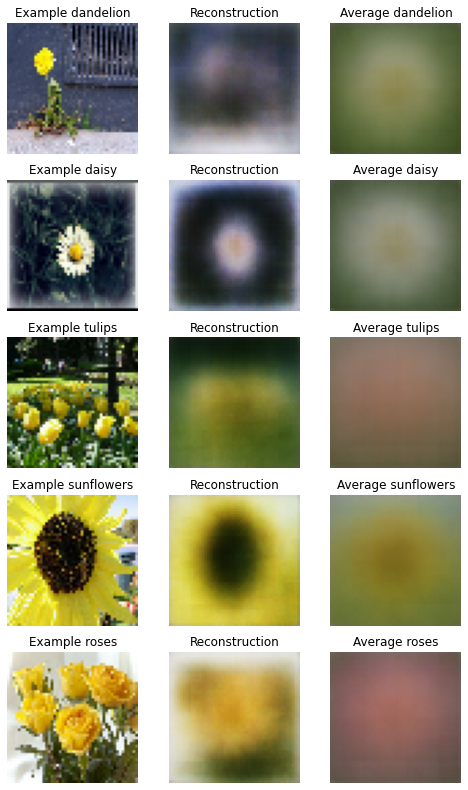

In [55]:
# compare examples, an example run through VAE
# and average flower
plt.figure(figsize=(14, 40))

for i, (k, v) in enumerate(flower_means.items()):
  original_example = flower_examples[k] 
  processed_example = vae.predict(original_example)
  average_flower = flower_means[k]['average_flower']

  ax = plt.subplot(14, 5, i * 5 + 1)
  plt.imshow(flower_examples[k][0])
  plt.title('Example ' + k)
  plt.axis('off')
  ax = plt.subplot(14, 5, i * 5 + 2)
  plt.imshow(processed_example[0])
  plt.title('Reconstruction')
  plt.axis('off')
  ax = plt.subplot(14, 5, i * 5 + 3)
  plt.imshow(average_flower)
  plt.title('Average ' + k)
  plt.axis("off")

## 11.
_Exercise: Train a DCGAN to tackle the image dataset of your choice, and use it to generate images. Add experience replay and see if this helps. Turn it into a conditional GAN where you can control the generated class._


## Flowers Dataset
...just smaller.

Continuing to use the Kaggle [Flowers Dataset](https://www.kaggle.com/datasets/l3llff/flowers), but reducing it to only sunflowers provides 1027 images of sunflowers.  The images are 96 x 96 RGB images, but I reduced them to 48 x 48.  After some experimentation, the 96 x 96 images did not perform well, but the 48 x 48 seemed better behaved.  

In [ ]:
!mkdir sample_data/flowers_small
!cp -r drive/MyDrive/Colab\ Notebooks/HandsOnML/Ch17_Q10/flowers/sunflower sample_data/flowers_small/.

First step is to import needed packages and set up global variables, and create a generator for the flower images.


In [ ]:
# imports and globals

import tensorflow as tf
from tensorflow import keras
K = keras.backend

import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

BATCH_SIZE = 32 

IMG_WIDTH  = 48 
IMG_HEIGHT = 48 

ENCODING_SIZE = 128 

In [ ]:
# create a training data generator 
training_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "sample_data/flowers_small",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None,
  color_mode = 'rgb'
)

training_generator = training_generator.prefetch(1)

# GAN

The GAN is based on the one presented in the book, but with a few modifications.

* The generator and discriminator have been adjusted for RGB images.
* Four convolutional layers are used, and the number of filters increases from 32 to 64 to 128.  I experimented with up to 4 convolutional layers and with more or less filters, but this seemed to produce the most reasonable results.
* Batch normalization was added to the discriminator and the results were very poor, so the final model has this removed.
* Dropout in the discriminator is critical.  Without it, the discriminator has a very hard time keeping pace with the generator.
* ReLU activations were tried in the generator, but generally produced very poor results.  SeLU performed well.
* A few experiments were done in which additional dense layers were added to the discriminator but these led to poorer results.
* The size of the encodings seemed to be very sensitive to the depth of the network and the size of the images. 

The interdependence of various hyperparameters made it very difficult to find a good balance witin the network.

In [ ]:
generator = keras.Sequential([
  keras.layers.Dense(128 * 3 * 3, activation = "selu", input_shape = [ENCODING_SIZE]),
  keras.layers.Reshape([3, 3, 128]),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 256, kernel_size = 3, strides = 1,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.Conv2DTranspose(filters = 3, kernel_size = 3, strides = 2,
                               padding = 'same', activation = 'sigmoid')
])
generator.summary()   

discriminator = keras.Sequential([
  keras.layers.Conv2D(32, input_shape = [IMG_WIDTH, IMG_HEIGHT, 3], kernel_size = 3, 
                      strides = 1, padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Conv2D(64, kernel_size = 3, strides = 2,
                      padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Conv2D(128, kernel_size = 3, strides = 2,
                      padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Conv2D(256, kernel_size = 3, strides = 2,
                      padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation = 'sigmoid')                                  
])
discriminator.summary()

gan = keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1152)              148608    
                                                                 
 reshape_1 (Reshape)         (None, 3, 3, 128)         0         
                                                                 
 batch_normalization_4 (Batc  (None, 3, 3, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 3, 3, 256)        295168    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 3, 3, 256)        1024      
 hNormalization)                                                 
                                                      

# Utility Functions

Some utility functions from the book were used with some modifications.

* Exponential decay of the learning rate was added.  When this wasn't present, the generated images would become more sunflower like and then quickly diverge away and then eventually become more sunflower like in later epochs.  This oscillatory behavior was largely controlled with a very small learning rate (which led to incredibly slow training) or exponential decay.
* In the _train_gain_ function, I added two accumulators with the actual image classes and the predicted classes from the discriminator.  This allowed me to add a confusion matrix and accuracy metric after each epoch to see how the discriminator performed.  This was very helpful to see when the discriminator was very poor and thus not providing good feedback to the generator.  
* A plotting option was added to allow showing examples of generated and actual sunflower every so often. 

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 3, n_rows * 3))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def exponential_decay_fn(epoch):
  return 0.01 * 0.1 ** (epoch / 50)

def train_gan(gan, dataset, BATCH_SIZE, ENCODING_SIZE, n_epochs = 50, plot_frequency = 10):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        preds = []
        actuals = []
        for X_batch in dataset:
          # give some feedback during the epoch
          print("=", end = '')
          X_batch /= 255

          # phase 1 - training the discriminator
          noise = tf.random.normal(shape=[len(X_batch), ENCODING_SIZE])
          generated_images = generator(noise)
          X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
          y1 = tf.constant([[0.]] * len(X_batch) + [[1.]] * len(X_batch))
          discriminator.trainable = True
          K.set_value(discriminator.optimizer.learning_rate, 
                      exponential_decay_fn(epoch))
          discriminator.train_on_batch(X_fake_and_real, y1)

          # capture the actual and predicted values for later
          actuals.extend([ y.numpy()[0] for y in y1])
          preds.extend([y[0] for y in discriminator.predict(X_fake_and_real).tolist()])

          # phase 2 - training the generator
          noise = tf.random.normal(shape=[len(X_batch), ENCODING_SIZE])
          y2 = tf.constant([[1.]] * len(X_batch))
          discriminator.trainable = False
          K.set_value(gan.optimizer.learning_rate, 
                      exponential_decay_fn(epoch))
          gan.train_on_batch(noise, y2)

        # print out a confusion matrix to see how the discriminator is doing
        print()
        print(confusion_matrix(actuals, [1 if p > 0.5 else 0 for p in preds]))
        print('accuracy: ', accuracy_score(actuals, [1 if p > 0.5 else 0 for p in preds]))

        # only plot every 10 epochs
        if epoch % plot_frequency == 0:
          plot_multiple_images(X_fake_and_real, 3)
          plt.show()
          
    plot_multiple_images(X_fake_and_real, 3)
    plt.show()

Epoch 1/250
[[676 351]
 [363 664]]
accuracy:  0.6523855890944499


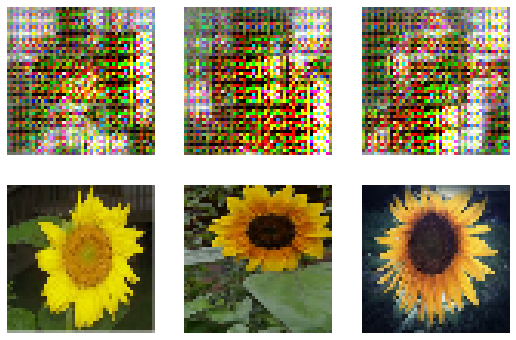

Epoch 2/250
[[660 367]
 [327 700]]
accuracy:  0.6621226874391432
Epoch 3/250
[[857 170]
 [215 812]]
accuracy:  0.8125608568646543
Epoch 4/250
[[740 287]
 [202 825]]
accuracy:  0.7619279454722493
Epoch 5/250
[[941  86]
 [322 705]]
accuracy:  0.801363193768257
Epoch 6/250
[[870 157]
 [447 580]]
accuracy:  0.7059396299902629
Epoch 7/250
[[885 142]
 [390 637]]
accuracy:  0.7409931840311588
Epoch 8/250
[[867 160]
 [402 625]]
accuracy:  0.7263875365141188
Epoch 9/250
[[845 182]
 [384 643]]
accuracy:  0.7244401168451802
Epoch 10/250
[[862 165]
 [457 570]]
accuracy:  0.697176241480039
Epoch 11/250
[[825 202]
 [428 599]]
accuracy:  0.6932814021421616


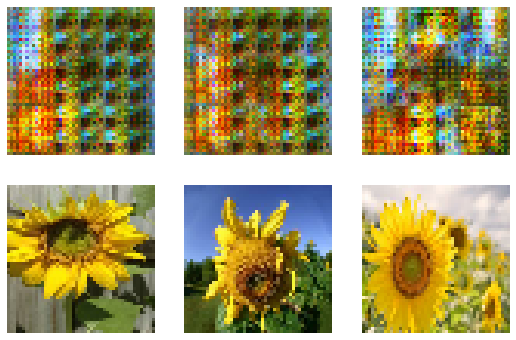

Epoch 12/250
[[803 224]
 [313 714]]
accuracy:  0.7385589094449854
Epoch 13/250
[[743 284]
 [360 667]]
accuracy:  0.6864654333008764
Epoch 14/250
[[860 167]
 [421 606]]
accuracy:  0.7137293086660176
Epoch 15/250
[[943  84]
 [428 599]]
accuracy:  0.750730282375852
Epoch 16/250
[[929  98]
 [346 681]]
accuracy:  0.7838364167478091
Epoch 17/250
[[913 114]
 [447 580]]
accuracy:  0.7268743914313535
Epoch 18/250
[[908 119]
 [442 585]]
accuracy:  0.7268743914313535
Epoch 19/250
[[800 227]
 [436 591]]
accuracy:  0.6772151898734177
Epoch 20/250
[[832 195]
 [355 672]]
accuracy:  0.7322297955209348
Epoch 21/250
[[880 147]
 [466 561]]
accuracy:  0.7015579357351509


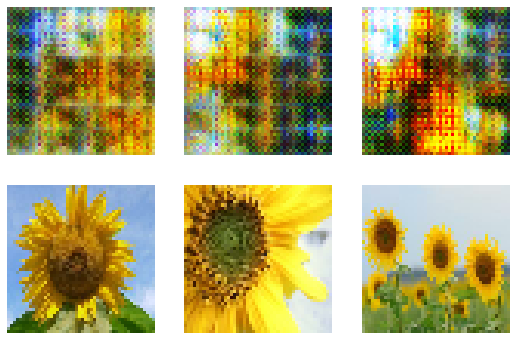

Epoch 22/250
[[825 202]
 [496 531]]
accuracy:  0.6601752677702045
Epoch 23/250
[[826 201]
 [458 569]]
accuracy:  0.6791626095423564
Epoch 24/250
[[839 188]
 [428 599]]
accuracy:  0.7000973709834469
Epoch 25/250
[[907 120]
 [361 666]]
accuracy:  0.7658227848101266
Epoch 26/250
[[912 115]
 [399 628]]
accuracy:  0.7497565725413826
Epoch 27/250
[[872 155]
 [312 715]]
accuracy:  0.7726387536514119
Epoch 28/250
[[889 138]
 [450 577]]
accuracy:  0.7137293086660176
Epoch 29/250
[[915 112]
 [320 707]]
accuracy:  0.7896786757546251
Epoch 30/250
[[938  89]
 [365 662]]
accuracy:  0.7789678675754625
Epoch 31/250
[[908 119]
 [372 655]]
accuracy:  0.76095423563778


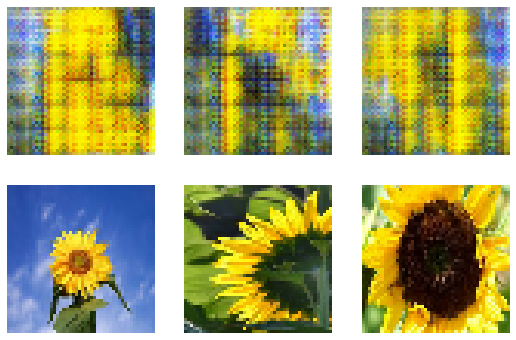

Epoch 32/250
[[863 164]
 [420 607]]
accuracy:  0.7156767283349562
Epoch 33/250
[[939  88]
 [376 651]]
accuracy:  0.7740993184031159
Epoch 34/250
[[906 121]
 [340 687]]
accuracy:  0.7755598831548198
Epoch 35/250
[[916 111]
 [502 525]]
accuracy:  0.7015579357351509
Epoch 36/250
[[886 141]
 [321 706]]
accuracy:  0.7750730282375852
Epoch 37/250
[[892 135]
 [374 653]]
accuracy:  0.752190847127556
Epoch 38/250
[[937  90]
 [409 618]]
accuracy:  0.7570593962999026
Epoch 39/250
[[884 143]
 [286 741]]
accuracy:  0.7911392405063291
Epoch 40/250
[[935  92]
 [391 636]]
accuracy:  0.7648490749756572
Epoch 41/250
[[966  61]
 [473 554]]
accuracy:  0.7400194741966893


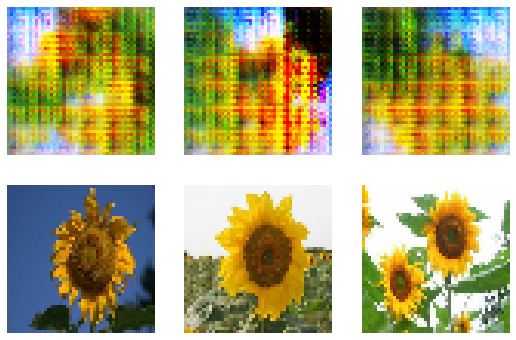

Epoch 42/250
[[878 149]
 [289 738]]
accuracy:  0.7867575462512172
Epoch 43/250
[[948  79]
 [370 657]]
accuracy:  0.7814021421616358
Epoch 44/250
[[934  93]
 [339 688]]
accuracy:  0.7896786757546251
Epoch 45/250
[[934  93]
 [446 581]]
accuracy:  0.737585199610516
Epoch 46/250
[[977  50]
 [327 700]]
accuracy:  0.8164556962025317
Epoch 47/250
[[868 159]
 [382 645]]
accuracy:  0.7366114897760467
Epoch 48/250
[[917 110]
 [233 794]]
accuracy:  0.8330087633885103
Epoch 49/250
[[923 104]
 [366 661]]
accuracy:  0.7711781888997079
Epoch 50/250
[[857 170]
 [349 678]]
accuracy:  0.7473222979552093
Epoch 51/250
[[966  61]
 [362 665]]
accuracy:  0.7940603700097371


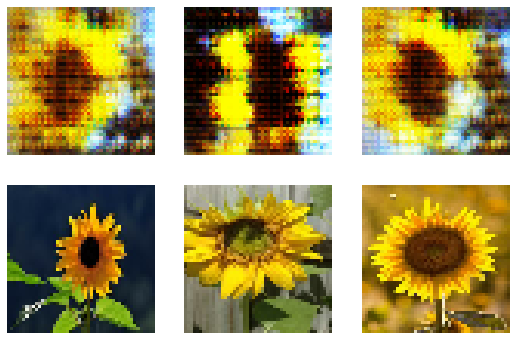

Epoch 52/250
[[963  64]
 [255 772]]
accuracy:  0.8446932814021422
Epoch 53/250
[[963  64]
 [347 680]]
accuracy:  0.7999026290165531
Epoch 54/250
[[941  86]
 [251 776]]
accuracy:  0.8359298928919182
Epoch 55/250
[[941  86]
 [295 732]]
accuracy:  0.814508276533593
Epoch 56/250
[[921 106]
 [302 725]]
accuracy:  0.801363193768257
Epoch 57/250
[[934  93]
 [310 717]]
accuracy:  0.8037974683544303
Epoch 58/250
[[922 105]
 [194 833]]
accuracy:  0.8544303797468354
Epoch 59/250
[[953  74]
 [334 693]]
accuracy:  0.801363193768257
Epoch 60/250
[[977  50]
 [227 800]]
accuracy:  0.865141187925998
Epoch 61/250
[[952  75]
 [315 712]]
accuracy:  0.810126582278481


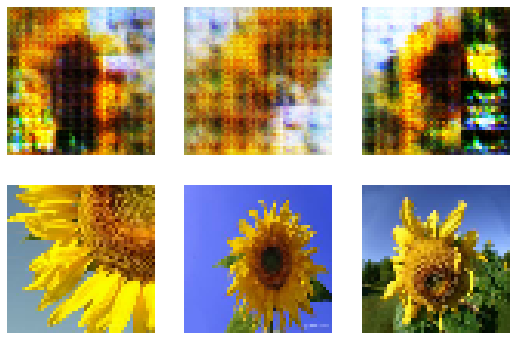

Epoch 62/250
[[941  86]
 [331 696]]
accuracy:  0.7969814995131451
Epoch 63/250
[[930  97]
 [281 746]]
accuracy:  0.815968841285297
Epoch 64/250
[[967  60]
 [244 783]]
accuracy:  0.8519961051606622
Epoch 65/250
[[965  62]
 [297 730]]
accuracy:  0.8252190847127556
Epoch 66/250
[[956  71]
 [264 763]]
accuracy:  0.8369036027263875
Epoch 67/250
[[978  49]
 [188 839]]
accuracy:  0.8846153846153846
Epoch 68/250
[[991  36]
 [279 748]]
accuracy:  0.8466407010710808
Epoch 69/250
[[1011   16]
 [ 219  808]]
accuracy:  0.8855890944498539
Epoch 70/250
[[939  88]
 [207 820]]
accuracy:  0.8563777994157741
Epoch 71/250
[[937  90]
 [237 790]]
accuracy:  0.8407984420642648


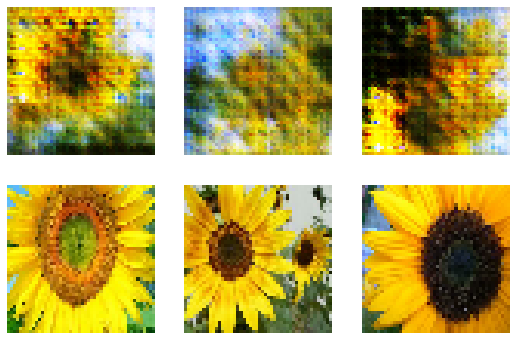

Epoch 72/250
[[1001   26]
 [ 269  758]]
accuracy:  0.8563777994157741
Epoch 73/250
[[1010   17]
 [ 236  791]]
accuracy:  0.8768257059396299
Epoch 74/250
[[976  51]
 [195 832]]
accuracy:  0.8802336903602727
Epoch 75/250
[[980  47]
 [199 828]]
accuracy:  0.8802336903602727
Epoch 76/250
[[1003   24]
 [ 184  843]]
accuracy:  0.8987341772151899
Epoch 77/250
[[1005   22]
 [ 249  778]]
accuracy:  0.868062317429406
Epoch 78/250
[[1020    7]
 [ 262  765]]
accuracy:  0.8690360272638754
Epoch 79/250
[[1002   25]
 [ 225  802]]
accuracy:  0.878286270691334
Epoch 80/250
[[1014   13]
 [ 177  850]]
accuracy:  0.9074975657254138
Epoch 81/250
[[1011   16]
 [ 196  831]]
accuracy:  0.8967867575462513


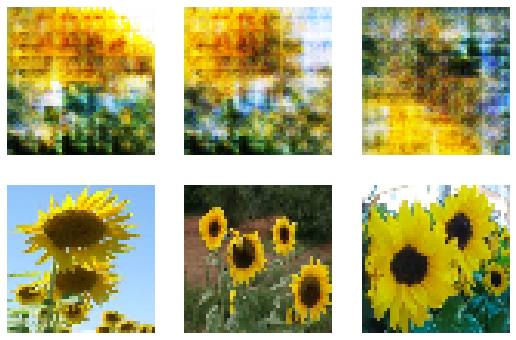

Epoch 82/250
[[1016   11]
 [ 206  821]]
accuracy:  0.8943524829600779
Epoch 83/250
[[1014   13]
 [ 239  788]]
accuracy:  0.8773125608568647
Epoch 84/250
[[1018    9]
 [ 183  844]]
accuracy:  0.9065238558909445
Epoch 85/250
[[1021    6]
 [ 192  835]]
accuracy:  0.9036027263875365
Epoch 86/250
[[1017   10]
 [ 203  824]]
accuracy:  0.8962999026290166
Epoch 87/250
[[1021    6]
 [ 224  803]]
accuracy:  0.8880233690360273
Epoch 88/250
[[1005   22]
 [ 239  788]]
accuracy:  0.8729308666017527
Epoch 89/250
[[1015   12]
 [ 192  835]]
accuracy:  0.9006815968841285
Epoch 90/250
[[1020    7]
 [ 164  863]]
accuracy:  0.9167478091528725
Epoch 91/250
[[1018    9]
 [ 144  883]]
accuracy:  0.9255111976630964


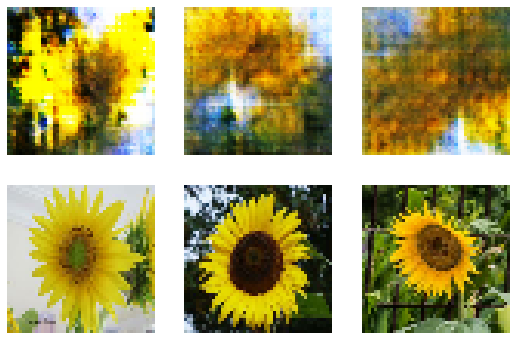

Epoch 92/250
[[1012   15]
 [ 155  872]]
accuracy:  0.9172346640701071
Epoch 93/250
[[1016   11]
 [ 143  884]]
accuracy:  0.9250243427458618
Epoch 94/250
[[1018    9]
 [ 155  872]]
accuracy:  0.9201557935735151
Epoch 95/250
[[1017   10]
 [ 167  860]]
accuracy:  0.9138266796494645
Epoch 96/250
[[1014   13]
 [ 179  848]]
accuracy:  0.9065238558909445
Epoch 97/250
[[1021    6]
 [ 162  865]]
accuracy:  0.9182083739045764
Epoch 98/250
[[1023    4]
 [ 156  871]]
accuracy:  0.9221032132424537
Epoch 99/250
[[1022    5]
 [ 151  876]]
accuracy:  0.9240506329113924
Epoch 100/250
[[1027    0]
 [ 153  874]]
accuracy:  0.9255111976630964
Epoch 101/250
[[1024    3]
 [ 144  883]]
accuracy:  0.9284323271665044


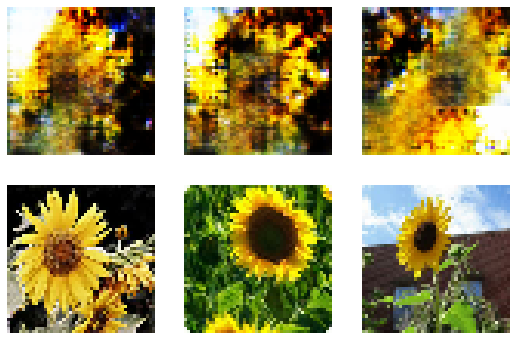

Epoch 102/250
[[1026    1]
 [ 150  877]]
accuracy:  0.9264849074975657
Epoch 103/250
[[1027    0]
 [ 128  899]]
accuracy:  0.937682570593963
Epoch 104/250
[[1027    0]
 [ 113  914]]
accuracy:  0.944985394352483
Epoch 105/250
[[1027    0]
 [ 113  914]]
accuracy:  0.944985394352483
Epoch 106/250
[[1027    0]
 [ 111  916]]
accuracy:  0.9459591041869523
Epoch 107/250
[[1025    2]
 [ 112  915]]
accuracy:  0.9444985394352483
Epoch 108/250
[[1027    0]
 [ 109  918]]
accuracy:  0.9469328140214216
Epoch 109/250
[[1027    0]
 [ 107  920]]
accuracy:  0.9479065238558909
Epoch 110/250
[[1024    3]
 [ 117  910]]
accuracy:  0.9415774099318404
Epoch 111/250
[[1024    3]
 [ 105  922]]
accuracy:  0.9474196689386563


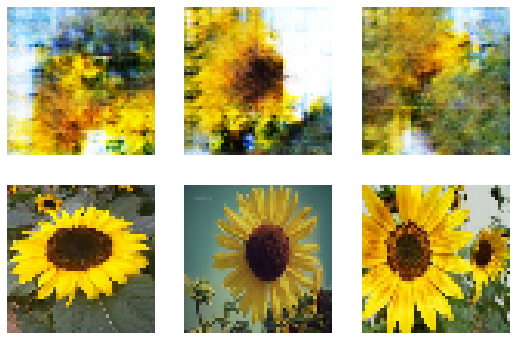

Epoch 112/250
[[1024    3]
 [ 124  903]]
accuracy:  0.9381694255111976
Epoch 113/250
[[1024    3]
 [ 126  901]]
accuracy:  0.9371957156767283
Epoch 114/250
[[1026    1]
 [ 133  894]]
accuracy:  0.934761441090555
Epoch 115/250
[[1022    5]
 [ 124  903]]
accuracy:  0.9371957156767283
Epoch 116/250
[[1025    2]
 [ 143  884]]
accuracy:  0.9294060370009737
Epoch 117/250
[[1027    0]
 [ 134  893]]
accuracy:  0.934761441090555
Epoch 118/250
[[1025    2]
 [ 123  904]]
accuracy:  0.939143135345667
Epoch 119/250
[[1026    1]
 [ 129  898]]
accuracy:  0.9367088607594937
Epoch 120/250
[[1027    0]
 [ 121  906]]
accuracy:  0.9410905550146057
Epoch 121/250
[[1027    0]
 [ 114  913]]
accuracy:  0.9444985394352483


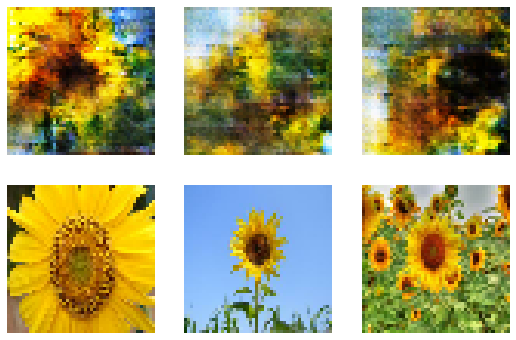

Epoch 122/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 123/250
[[1026    1]
 [ 107  920]]
accuracy:  0.9474196689386563
Epoch 124/250
[[1027    0]
 [ 114  913]]
accuracy:  0.9444985394352483
Epoch 125/250
[[1027    0]
 [ 110  917]]
accuracy:  0.9464459591041869
Epoch 126/250
[[1027    0]
 [ 109  918]]
accuracy:  0.9469328140214216
Epoch 127/250
[[1026    1]
 [ 113  914]]
accuracy:  0.9444985394352483
Epoch 128/250
[[1027    0]
 [ 112  915]]
accuracy:  0.9454722492697176
Epoch 129/250
[[1027    0]
 [ 106  921]]
accuracy:  0.9483933787731256
Epoch 130/250
[[1027    0]
 [ 112  915]]
accuracy:  0.9454722492697176
Epoch 131/250
[[1026    1]
 [ 122  905]]
accuracy:  0.9401168451801363


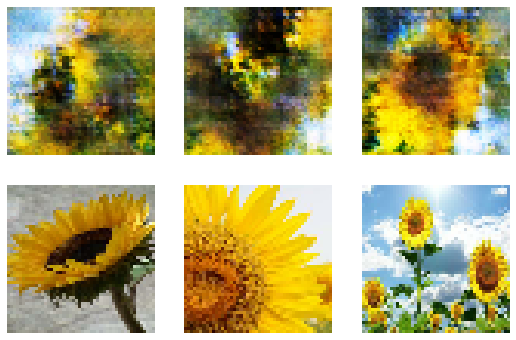

Epoch 132/250
[[1025    2]
 [ 122  905]]
accuracy:  0.9396299902629016
Epoch 133/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 134/250
[[1026    1]
 [ 133  894]]
accuracy:  0.934761441090555
Epoch 135/250
[[1026    1]
 [ 118  909]]
accuracy:  0.942064264849075
Epoch 136/250
[[1027    0]
 [ 121  906]]
accuracy:  0.9410905550146057
Epoch 137/250
[[1027    0]
 [ 124  903]]
accuracy:  0.9396299902629016
Epoch 138/250
[[1027    0]
 [ 128  899]]
accuracy:  0.937682570593963
Epoch 139/250
[[1026    1]
 [ 131  896]]
accuracy:  0.9357351509250244
Epoch 140/250
[[1027    0]
 [ 129  898]]
accuracy:  0.9371957156767283
Epoch 141/250
[[1026    1]
 [ 136  891]]
accuracy:  0.9333008763388511


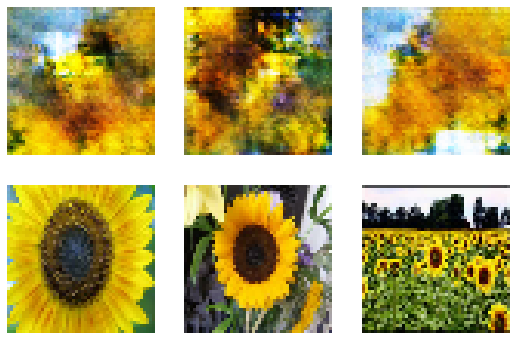

Epoch 142/250
[[1024    3]
 [ 124  903]]
accuracy:  0.9381694255111976
Epoch 143/250
[[1025    2]
 [ 127  900]]
accuracy:  0.9371957156767283
Epoch 144/250
[[1027    0]
 [ 145  882]]
accuracy:  0.9294060370009737
Epoch 145/250
[[1027    0]
 [ 131  896]]
accuracy:  0.936222005842259
Epoch 146/250
[[1027    0]
 [ 128  899]]
accuracy:  0.937682570593963
Epoch 147/250
[[1027    0]
 [ 130  897]]
accuracy:  0.9367088607594937
Epoch 148/250
[[1027    0]
 [ 131  896]]
accuracy:  0.936222005842259
Epoch 149/250
[[1027    0]
 [ 129  898]]
accuracy:  0.9371957156767283
Epoch 150/250
[[1026    1]
 [ 128  899]]
accuracy:  0.9371957156767283
Epoch 151/250
[[1026    1]
 [ 124  903]]
accuracy:  0.939143135345667


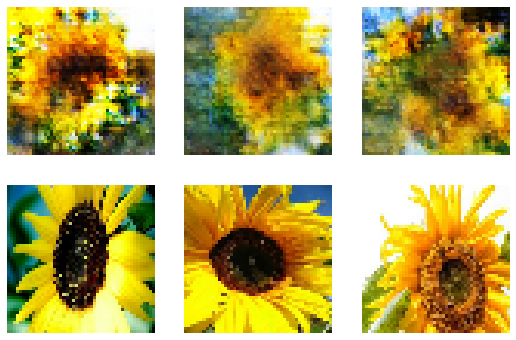

Epoch 152/250
[[1027    0]
 [ 115  912]]
accuracy:  0.9440116845180136
Epoch 153/250
[[1027    0]
 [ 131  896]]
accuracy:  0.936222005842259
Epoch 154/250
[[1026    1]
 [ 123  904]]
accuracy:  0.9396299902629016
Epoch 155/250
[[1027    0]
 [ 133  894]]
accuracy:  0.9352482960077897
Epoch 156/250
[[1027    0]
 [ 129  898]]
accuracy:  0.9371957156767283
Epoch 157/250
[[1026    1]
 [ 126  901]]
accuracy:  0.9381694255111976
Epoch 158/250
[[1026    1]
 [ 133  894]]
accuracy:  0.934761441090555
Epoch 159/250
[[1027    0]
 [ 130  897]]
accuracy:  0.9367088607594937
Epoch 160/250
[[1027    0]
 [ 125  902]]
accuracy:  0.939143135345667
Epoch 161/250
[[1027    0]
 [ 121  906]]
accuracy:  0.9410905550146057


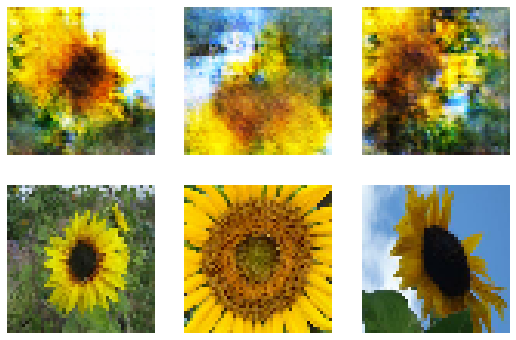

Epoch 162/250
[[1026    1]
 [ 126  901]]
accuracy:  0.9381694255111976
Epoch 163/250
[[1027    0]
 [ 127  900]]
accuracy:  0.9381694255111976
Epoch 164/250
[[1027    0]
 [ 130  897]]
accuracy:  0.9367088607594937
Epoch 165/250
[[1026    1]
 [ 123  904]]
accuracy:  0.9396299902629016
Epoch 166/250
[[1027    0]
 [ 127  900]]
accuracy:  0.9381694255111976
Epoch 167/250
[[1027    0]
 [ 127  900]]
accuracy:  0.9381694255111976
Epoch 168/250
[[1027    0]
 [ 123  904]]
accuracy:  0.9401168451801363
Epoch 169/250
[[1026    1]
 [ 122  905]]
accuracy:  0.9401168451801363
Epoch 170/250
[[1027    0]
 [ 122  905]]
accuracy:  0.9406037000973709
Epoch 171/250
[[1026    1]
 [ 126  901]]
accuracy:  0.9381694255111976


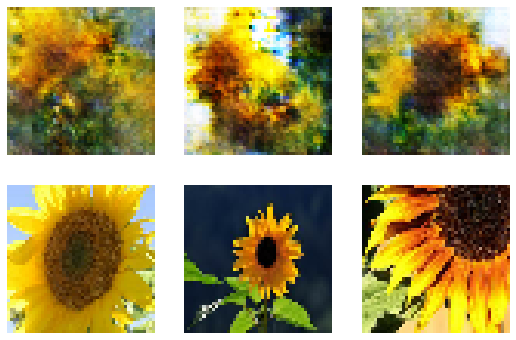

Epoch 172/250
[[1027    0]
 [ 124  903]]
accuracy:  0.9396299902629016
Epoch 173/250
[[1027    0]
 [ 125  902]]
accuracy:  0.939143135345667
Epoch 174/250
[[1027    0]
 [ 122  905]]
accuracy:  0.9406037000973709
Epoch 175/250
[[1027    0]
 [ 121  906]]
accuracy:  0.9410905550146057
Epoch 176/250
[[1026    1]
 [ 121  906]]
accuracy:  0.9406037000973709
Epoch 177/250
[[1027    0]
 [ 126  901]]
accuracy:  0.9386562804284323
Epoch 178/250
[[1026    1]
 [ 119  908]]
accuracy:  0.9415774099318404
Epoch 179/250
[[1027    0]
 [ 129  898]]
accuracy:  0.9371957156767283
Epoch 180/250
[[1027    0]
 [ 125  902]]
accuracy:  0.939143135345667
Epoch 181/250
[[1026    1]
 [ 123  904]]
accuracy:  0.9396299902629016


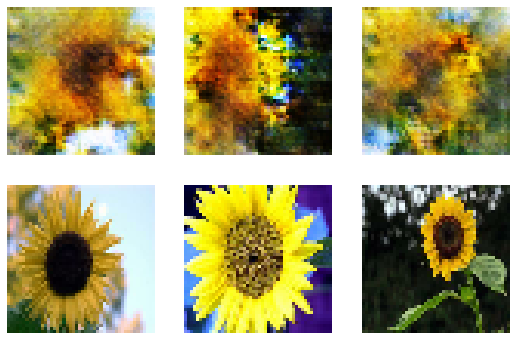

Epoch 182/250
[[1027    0]
 [ 116  911]]
accuracy:  0.943524829600779
Epoch 183/250
[[1027    0]
 [ 122  905]]
accuracy:  0.9406037000973709
Epoch 184/250
[[1026    1]
 [ 125  902]]
accuracy:  0.9386562804284323
Epoch 185/250
[[1027    0]
 [ 121  906]]
accuracy:  0.9410905550146057
Epoch 186/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 187/250
[[1027    0]
 [ 115  912]]
accuracy:  0.9440116845180136
Epoch 188/250
[[1027    0]
 [ 115  912]]
accuracy:  0.9440116845180136
Epoch 189/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 190/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 191/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404


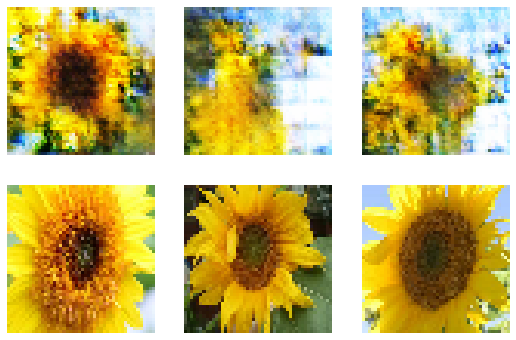

Epoch 192/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 193/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 194/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 195/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 196/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 197/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 198/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 199/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 200/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 201/250
[[1027    0]
 [ 121  906]]
accuracy:  0.9410905550146057


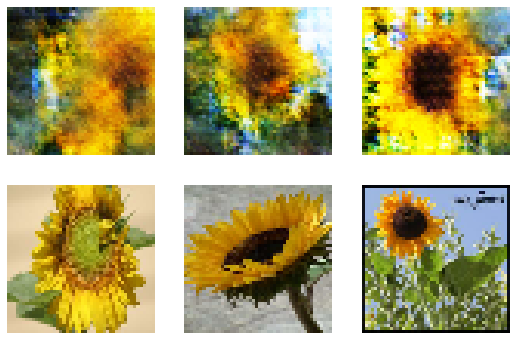

Epoch 202/250
[[1027    0]
 [ 121  906]]
accuracy:  0.9410905550146057
Epoch 203/250
[[1026    1]
 [ 122  905]]
accuracy:  0.9401168451801363
Epoch 204/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 205/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 206/250
[[1026    1]
 [ 118  909]]
accuracy:  0.942064264849075
Epoch 207/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 208/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 209/250
[[1027    0]
 [ 121  906]]
accuracy:  0.9410905550146057
Epoch 210/250
[[1027    0]
 [ 121  906]]
accuracy:  0.9410905550146057
Epoch 211/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097


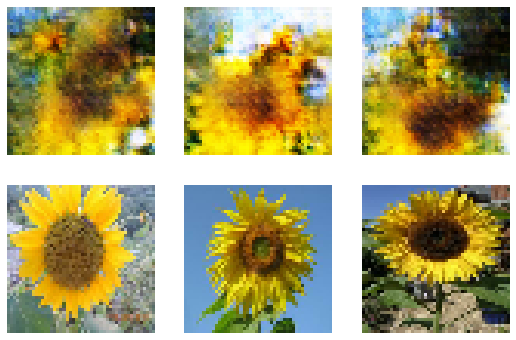

Epoch 212/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 213/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 214/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 215/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 216/250
[[1026    1]
 [ 118  909]]
accuracy:  0.942064264849075
Epoch 217/250
[[1026    1]
 [ 119  908]]
accuracy:  0.9415774099318404
Epoch 218/250
[[1026    1]
 [ 119  908]]
accuracy:  0.9415774099318404
Epoch 219/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 220/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 221/250
[[1027    0]
 [ 117  910]]
accuracy:  0.9430379746835443


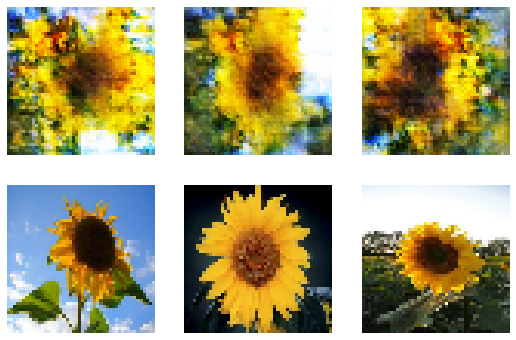

Epoch 222/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 223/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 224/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 225/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 226/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 227/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 228/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 229/250
[[1026    1]
 [ 119  908]]
accuracy:  0.9415774099318404
Epoch 230/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 231/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404


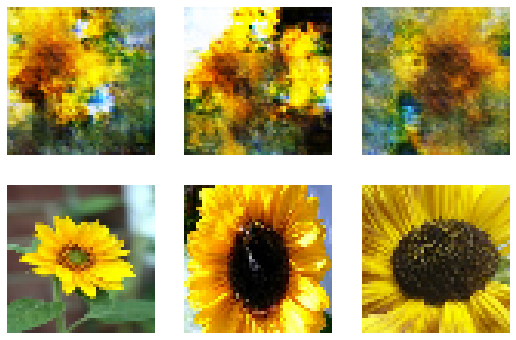

Epoch 232/250
[[1026    1]
 [ 120  907]]
accuracy:  0.9410905550146057
Epoch 233/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 234/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 235/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 236/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 237/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 238/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 239/250
[[1027    0]
 [ 119  908]]
accuracy:  0.942064264849075
Epoch 240/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 241/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404


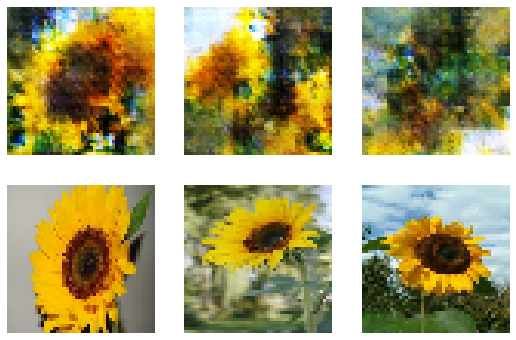

Epoch 242/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 243/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 244/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 245/250
[[1027    0]
 [ 120  907]]
accuracy:  0.9415774099318404
Epoch 246/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 247/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 248/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 249/250
[[1027    0]
 [ 118  909]]
accuracy:  0.9425511197663097
Epoch 250/250
[[1026    1]
 [ 118  909]]
accuracy:  0.942064264849075


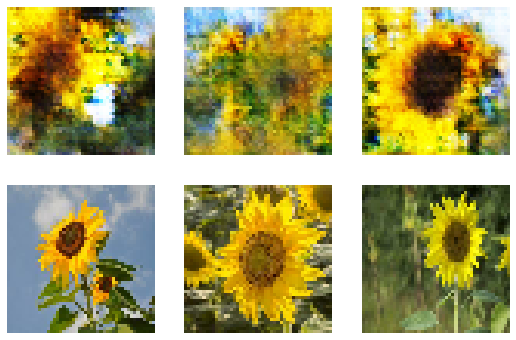

In [ ]:
# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

discriminator.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Nadam())
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Nadam())

train_gan(gan, training_generator, BATCH_SIZE, ENCODING_SIZE, n_epochs = 250, plot_frequency = 10)

# Conclusions

In early epochs, the generator essentially learns the color palette first.  In some examples, depending on the size of the images, the depth of the network, etc., the first few epoch were clearly noise in the wrong color space, but would quickly change to the right set of yellows and reds.  Within a few more epochs, a color separation in the images with blue on top, yellow in the middle, and darker (generally greenish) on the bottom, showing that the generator was learing the general structure of the images.  Along the way, more circular shapes would begin to emerge, and eventually some images that had some sunflower characteristics were produced.  Granted, these will not fool anyone, but there's clearly a learning process happening.

It was clear that larger images were much harder, and reducing the images to 48 x 48 helped.  Reducing the images further was helpful, but then the real images were themselves less convincing.  

Deeper network with 4 or 5 convolutional layers and as many as 1024 filters in the deepest layer also improved the images, but only slightly.

Clear limitations of this approach include:
* there were only 1027 images in the real image set
* the images were not very consistently framed - some have wonderfully centered flowers, but there are many camera angles, and many images of fields of sunflowers
* much larger and more complex networks might help, but more training data will probably be more impactful

Also interesting is the periodicity observed in the generated images.  There are repeated pattern blocks that are clearly reflective of the underlying network structure and weights.  I'm quite surprised at the degree of periodicity, however.  A more thorough investigation of the weights of each layer of the network would be interesting to determine why there are such periodic or symmetric structures.